<a href="https://colab.research.google.com/github/IceHoles/ml/blob/main/practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задача 1: Подготовка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import ast  # Модуль для преобразования строки в список
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/flat_novosib.csv'

# Загрузка файла данных
data = pd.read_csv(file_path)
data = data.astype(str) # Почему-то после чтения тип файлов не определяется как str, поэтому я привожу его к str для последующей обработки и приведения к float если требуется
print(data.columns)

Mounted at /content/drive
Index(['Ссылка', 'Точный адрес', 'Долгота', 'Широта', 'Ценовая зона',
       'Расстояние до центра', 'Расстояние до метро',
       'Расстояние до остановки', 'Расстояние до школы', 'Расстояние до КАД',
       'Заголовок', 'Описание', 'Тип рынка', 'Тип сделки', 'Город', 'Сегмент',
       'Класс', 'Год постройки_', 'Год постройки', 'Высота поталков', 'Этажей',
       'Этажей_', 'Количество комнат', 'Количество просмотров', 'Парковка',
       'Отопление', 'Электричество', 'Водопровод', 'Канализация', 'Газ',
       'Ремонт', 'Материал стен', 'Общая площадь, кв.м', 'Жилая площадь, кв.м',
       'Площадь кухни, кв.м', 'Цена, руб', 'Удельная цена руб/кв.м',
       'Дата парсинга', 'Дата создания'],
      dtype='object')


Всего имеем 15000 строк и 37 столбцов, но можно заметить, что некоторые из них повторяются, некоторые заполнены разрежено и некоторые не несут полезной информации, например в столбце "Точный адрес" у многих объектов адрес указан просто как "город ...", что не дает нам никакой уточняющей информации. Удалим их чуть позже

In [ ]:
# Объединение столбцов 'Год постройки_' и 'Год постройки'
data['Год постройки'] = data['Год постройки'].fillna(data['Год постройки_'])

# Объединение столбцов 'Этажей' и 'Этажей_'
data['Этажей_'] = data['Этажей_'].fillna(data['Этажей'])
mode_floors = data['Этажей_'].mode()[0]
data['Этажей_'] = data['Этажей_'].fillna(mode_floors)
# Преобразование строки в список
data['Ценовая зона'] = data['Ценовая зона'].apply(lambda x: x.split(',')[0].strip("[]'"))

# Создание DataFrame с числовыми и нечисловыми столбцами
numeric_features = ['Долгота', 'Широта', 'Расстояние до центра', 'Год постройки', 'Общая площадь, кв.м', 'Цена, руб', 'Удельная цена руб/кв.м', 'Высота поталков', 'Количество комнат', 'Этажей_', 'Жилая площадь, кв.м',
       'Площадь кухни, кв.м',]
non_numeric_features = ['Ценовая зона', 'Тип рынка', 'Материал стен', 'Парковка']

# Подсчет количества уникальных значений в каждом столбце
unique_counts = data.nunique()
print(unique_counts)

Ссылка                     15000
Точный адрес                3254
Долгота                     3038
Широта                      3111
Ценовая зона                  10
Расстояние до центра        2924
Расстояние до метро         2921
Расстояние до остановки     2937
Расстояние до школы         2928
Расстояние до КАД              2
Заголовок                  13318
Описание                   12506
Тип рынка                      2
Тип сделки                     1
Город                          1
Сегмент                        1
Класс                          2
Год постройки_                99
Год постройки                 47
Высота поталков                1
Этажей                        30
Этажей_                       35
Количество комнат              7
Количество просмотров         70
Парковка                      13
Отопление                      7
Электричество                  2
Водопровод                     3
Канализация                    4
Газ                            4
Ремонт    

Также можно заметить, что имеется много вхождений одинаковых объектов, но с разными датами парсинга и ценами. Как видно из результата data.nunique() у всех строчек ссылки разные, значит нужно поймать дубликаты, основываясь на других столбцах.

In [ ]:
# Вывести уникальные значения категориальных признаков
for feature in non_numeric_features:
    print(data[feature].value_counts())
    print('\n')
#print(data['Этажей_'].value_counts())

Ценовая зона
Многоквартирная жилая застройка    7705
Исторический центр города          3365
Окраины                             958
nan                                 787
Промзоны                            713
ИЖС                                 687
                                    455
Зона автомагистралей                275
Зеленая зона                         54
Центры деловой активности             1
Name: count, dtype: int64


Тип рынка
Первичный    9189
Вторичный    5811
Name: count, dtype: int64


Материал стен
nan           9850
Кирпичный     2244
Смешанный      967
Монолитный     635
Деревянный     492
Панельный      478
Блочный        330
Шлакоблоки       4
Name: count, dtype: int64


Парковка
nan                        10391
Есть                        2704
Подземная                   1641
да                            99
многоуровневая                69
предусмотрена                 33
наземная                      22
гостевая                      17
Подземная, 148 м/м

Отсюда видно, что столбцы Парковка, Отопление, Ремонт заполнены меньше чем на 2/3, имеет смысл их убрать

Также уберу столбцы, которые не буду использовать: адрес и все что с ним связано (Координаты и столбцы "Расстояние до ..."), заголовок, описание, все столбцы, у которых одинаковое значение во всех строчках (Тип сделки, город, сегмент)

In [ ]:
# Преобразование строковых значений в числа для столбцов из numeric_features
for feature in numeric_features:
    data[feature] = pd.to_numeric(data[feature].str.replace(',', '.'), errors='coerce')

In [ ]:
# Оценка числовых признаков
print(data[numeric_features].describe())

            Долгота        Широта  Расстояние до центра  Год постройки  \
count  15000.000000  15000.000000          1.243200e+04     424.000000   
mean      81.522760     54.848143          5.476757e+04    2019.056604   
std       10.528720      1.245784          5.158240e+05      13.460971   
min      -71.006568     40.572505          0.000000e+00    1933.000000   
25%       82.902715     54.981691          1.003987e+03    2022.000000   
50%       82.920430     55.030204          5.044540e+03    2024.000000   
75%       82.958276     55.047956          8.658326e+03    2025.000000   
max       88.371604     69.492151          9.555683e+06    2026.000000   

       Общая площадь, кв.м     Цена, руб  Удельная цена руб/кв.м  \
count         15000.000000  1.500000e+04            1.500000e+04   
mean             51.904397  6.768167e+06            1.307066e+05   
std              26.435435  4.303681e+06            4.081922e+04   
min              11.000000  3.600000e+05            7.500000e

Столбцы Год постройки, Высота поталков заполнены очень редко, их тоже следует убрать

In [ ]:
# Функция для вычисления расстояния между двумя точками на основе их широты и долготы
def haversine(lat1, lon1):
    R = 6371.0  # Радиус Земли в километрах
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(55.030204)
    lon2_rad = math.radians(82.92043)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [ ]:
#Считаем количество строк до удаления дубликатов
num_rows = data.shape[0]
print(f'Количество строк до удаления дубликатов:{num_rows}')

# Удаление дубликатов по всем уникальным отличающимся признакам, оставляю объект с минимальной ценой
#data.sort_values(by='Цена, руб', ascending=True, inplace=True)
#data.drop_duplicates(subset=['Точный адрес', 'Долгота', 'Широта', 'Ценовая зона', 'Тип рынка', 'Материал стен', 'Парковка', 'Общая площадь, кв.м', 'Год постройки',  'Количество комнат', 'Жилая площадь, кв.м'], keep='first', inplace=True)

# Вычисление расстояния до центра исходя из столбцов с координатами
data = data[data['Долгота'] < 83.13]
data = data[data['Долгота'] > 82.7]
data['Расстояние до центра'] = data.apply(lambda row: haversine(row['Широта'], row['Долгота']), axis=1)

# Удаление столбцов с неиспользуемыми данными 'Долгота', 'Широта',
non_used_columns = ['Ссылка', 'Точный адрес', 'Долгота', 'Широта',
       'Расстояние до метро',
       'Расстояние до остановки', 'Расстояние до школы', 'Расстояние до КАД',
       'Заголовок', 'Описание', 'Тип сделки', 'Город', 'Сегмент',
       'Класс', 'Год постройки_', 'Высота поталков', 'Этажей',
       'Количество просмотров', 'Цена, руб',
       'Отопление', 'Электричество', 'Водопровод', 'Канализация', 'Газ',
       'Ремонт', 'Дата парсинга', 'Дата создания', 'Материал стен', 'Парковка']
data = data.drop(columns=non_used_columns)

# Обновление набора столбцов с используемыми числовыми и нечисловыми столбцами
numeric_features = ['Расстояние до центра', 'Общая площадь, кв.м', 'Удельная цена руб/кв.м', 'Этажей_', 'Год постройки',  'Количество комнат', 'Жилая площадь, кв.м']
non_numeric_features = ['Ценовая зона', 'Тип рынка']

print(f'Количество строк после удаления дубликатов:{data.shape[0]}')
print(f'Всего удалено дубликатов:{num_rows - data.shape[0]}')
print(data.columns)

Количество строк до удаления дубликатов:15000
Количество строк после удаления дубликатов:14603
Всего удалено дубликатов:397
Index(['Ценовая зона', 'Расстояние до центра', 'Тип рынка', 'Год постройки',
       'Этажей_', 'Количество комнат', 'Общая площадь, кв.м',
       'Жилая площадь, кв.м', 'Площадь кухни, кв.м', 'Удельная цена руб/кв.м'],
      dtype='object')


In [ ]:
# Вывести значения категориальных признаков
for feature in non_numeric_features:
    print(data[feature].value_counts())
    print('')

# Оценка числовых признаков
print(data[numeric_features].describe())

Ценовая зона
Многоквартирная жилая застройка    7705
Исторический центр города          3364
Окраины                             958
nan                                 779
Промзоны                            713
ИЖС                                 687
Зона автомагистралей                275
                                     67
Зеленая зона                         54
Центры деловой активности             1
Name: count, dtype: int64

Тип рынка
Первичный    8802
Вторичный    5801
Name: count, dtype: int64

       Расстояние до центра  Общая площадь, кв.м  Удельная цена руб/кв.м  \
count          14603.000000         14603.000000            1.460300e+04   
mean               5.457354            51.858706            1.304979e+05   
std                4.645118            26.571751            4.107588e+04   
min                0.000000            11.000000            7.500000e+03   
25%                1.721338            36.330000            1.004383e+05   
50%                4.969376    

В ценовых зонах целесообразно оставить "", "Многоквартирная жилая застройка", а остальные категории обединить в одну.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Многоквартирная жилая застройка'),
  Text(1, 0, 'Исторический центр города'),
  Text(2, 0, 'Окраины'),
  Text(3, 0, 'nan'),
  Text(4, 0, 'Промзоны'),
  Text(5, 0, 'ИЖС'),
  Text(6, 0, 'Зона автомагистралей'),
  Text(7, 0, ''),
  Text(8, 0, 'Зеленая зона'),
  Text(9, 0, 'Центры деловой активности')])

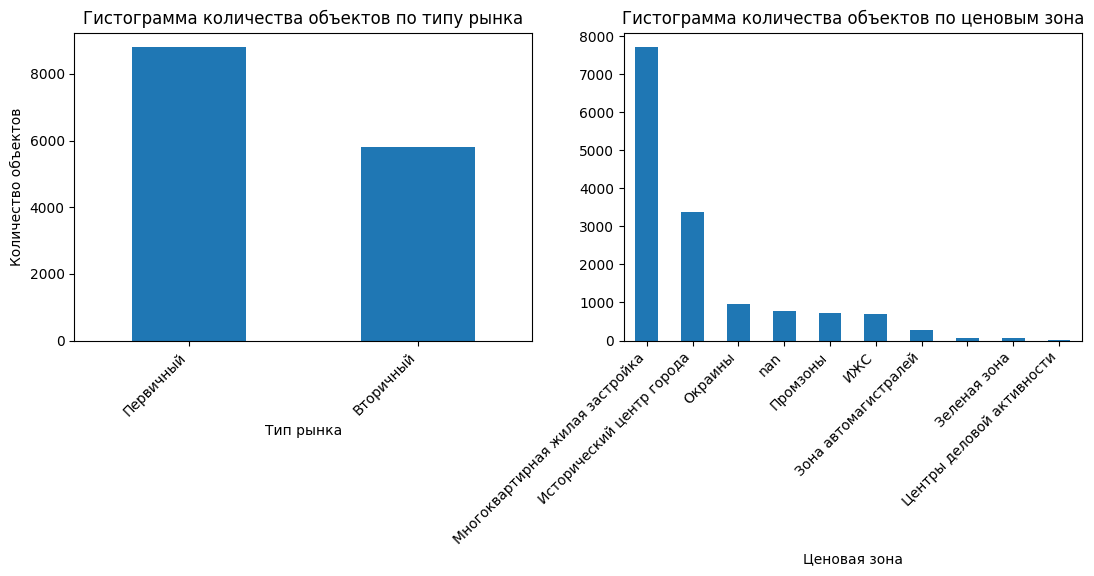

In [ ]:
# Построение столбиковых диаграмм для категориальных признаков
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

ax = axs[0]
plt.sca(ax)
data['Тип рынка'].value_counts().plot(kind='bar')
plt.title('Гистограмма количества объектов по типу рынка')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Количество объектов')

ax = axs[1]
plt.sca(ax)
data['Ценовая зона'].value_counts().plot(kind='bar')
plt.title('Гистограмма количества объектов по ценовым зона')
plt.xticks(rotation=45, ha='right')

Как мы видим, типы рынков разделяются на первичный и вторичный

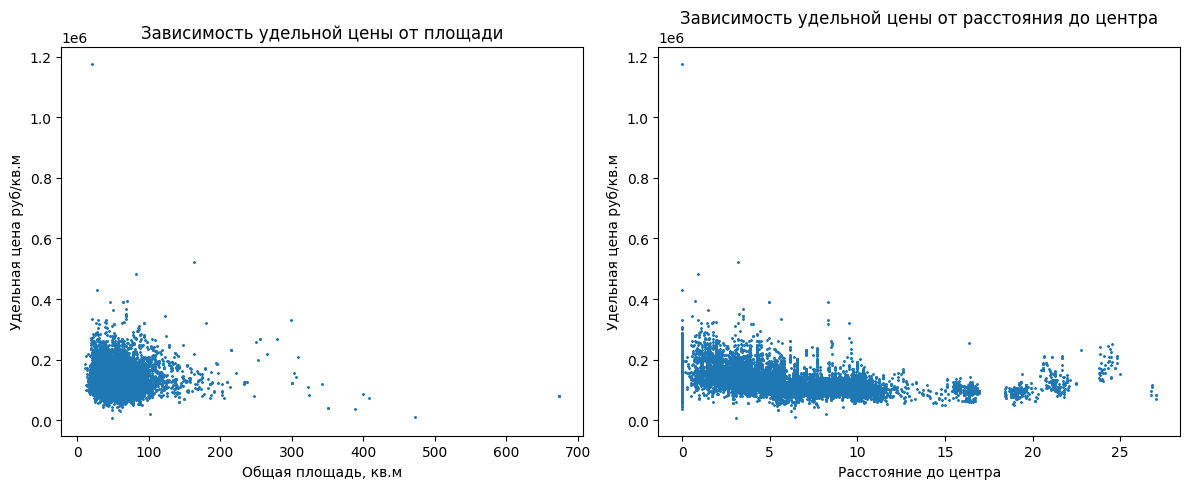

In [ ]:
#Построение зависимости удельной цены от площади
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
plt.sca(ax)
plt.scatter(data['Общая площадь, кв.м'], data['Удельная цена руб/кв.м'], s=1, marker='X')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Удельная цена руб/кв.м')
plt.title('Зависимость удельной цены от площади')

ax = axs[1]
plt.sca(ax)
plt.scatter(data['Расстояние до центра'], data['Удельная цена руб/кв.м'], s=1, marker='X')
plt.xlabel('Расстояние до центра')
plt.ylabel('Удельная цена руб/кв.м')
plt.title('Зависимость удельной цены от расстояния до центра')
plt.tight_layout()
plt.show()

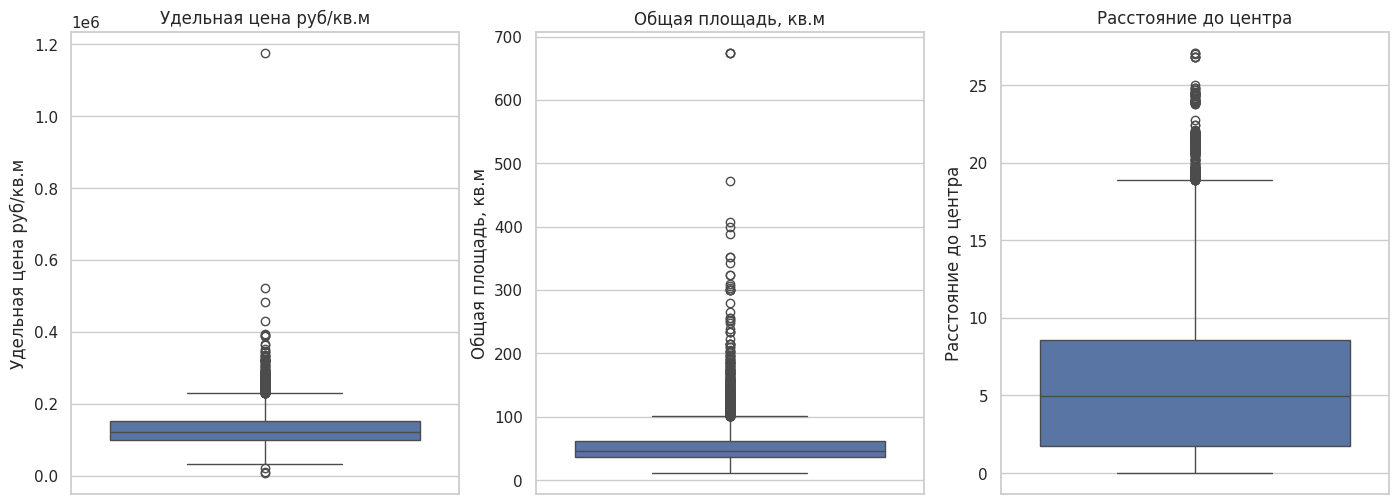

In [ ]:
sns.set(style="whitegrid")
# Выбираем столбцы для анализа
columns_to_analyze = ['Удельная цена руб/кв.м', 'Общая площадь, кв.м','Расстояние до центра']

# Создаем боксплоты для каждого столбца
plt.figure(figsize=(17, 6))
for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(1, len(columns_to_analyze), i)
    sns.boxplot(y=data[column])
    plt.title(f'{column}')
plt.show()

На графиках можно заметить точки, сильно отдаленные от основной массы, уберем все что не попадает в интерквантильный размах

Удалено строк с выбросами: 767


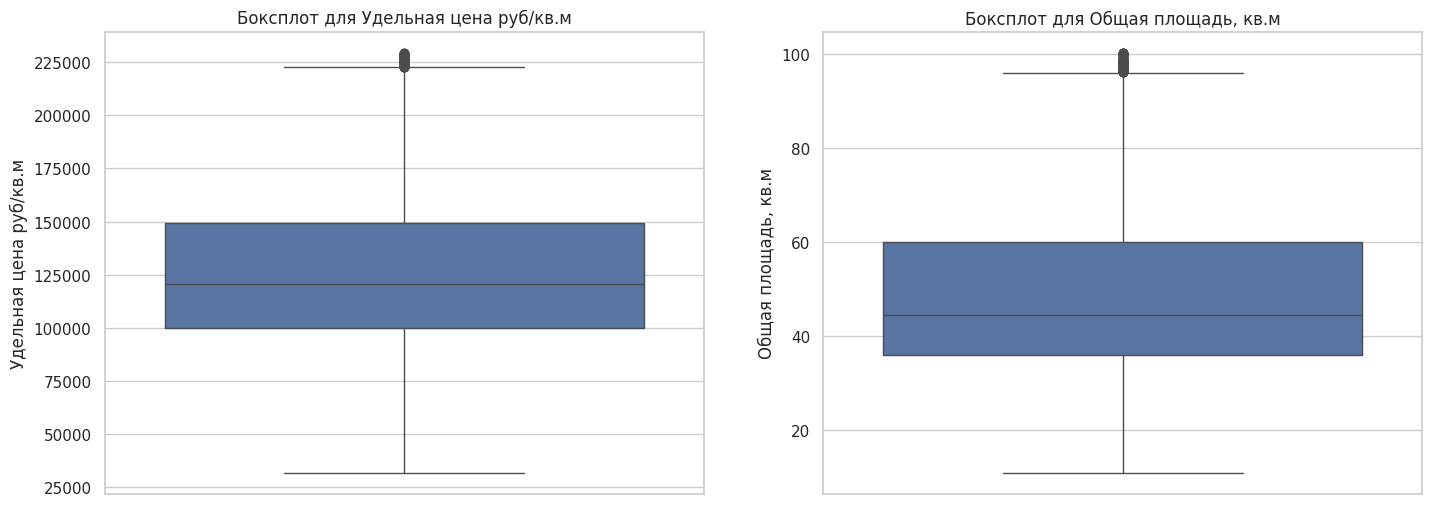

Количество строк после удаления выбросов:13836


In [ ]:
df = data

columns_to_analyze = ['Удельная цена руб/кв.м', 'Общая площадь, кв.м']

# Задаем порог для определения выбросов
outlier_threshold = 1.5

# Создаем копию DataFrame, чтобы не изменять оригинал
df_no_outliers = df.copy()

# Удаляем строки с выбросами
for column in columns_to_analyze:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - outlier_threshold * iqr
    upper_bound = q3 + outlier_threshold * iqr

    df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]
# df_no_outliers = df_no_outliers[df_no_outliers['Долгота'] > 29]
# Выводим информацию о том, сколько строк удалено
print(f"Удалено строк с выбросами: {len(df) - len(df_no_outliers)}")

# Выводим боксплоты после удаления выбросов
plt.figure(figsize=(17, 6))
for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(1, len(columns_to_analyze), i)
    sns.boxplot(y=df_no_outliers[column].dropna())
    plt.title(f'Боксплот для {column}')

plt.show()
print(f'Количество строк после удаления выбросов:{df_no_outliers.shape[0]}')

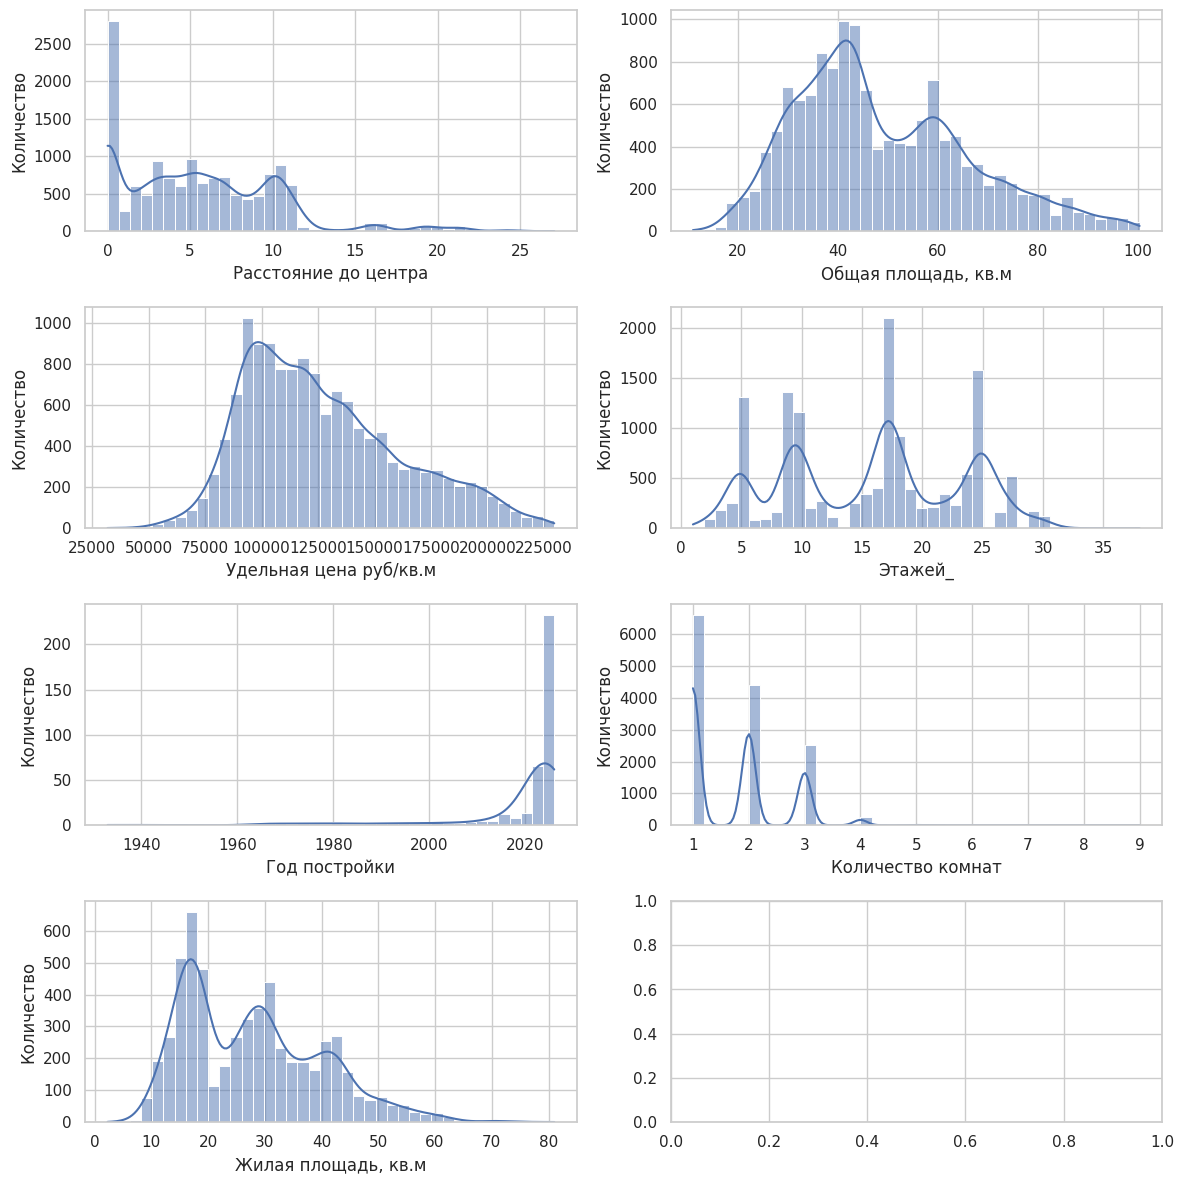

Количество комнат
1    6791
2    4558
3    2773
4     420
5      58
7       2
9       1
Name: count, dtype: int64


In [ ]:
# Построение гистограмм для числовых признаков
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
i = 0
for feature in numeric_features:
    ax = axs[i // 2, i % 2]
    sns.histplot(data=df_no_outliers, x=feature, bins=40, kde=True, ax=ax)
    #ax.set_title(f'Гистограмма для {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Количество')
    i += 1
plt.tight_layout()
plt.show()
print(data['Количество комнат'].value_counts())

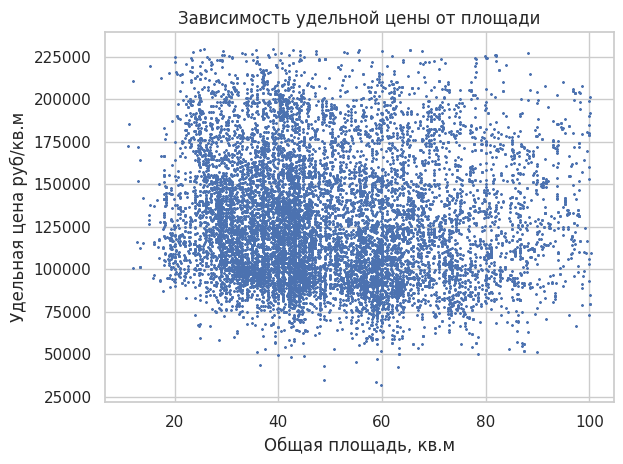

In [ ]:
#Построение зависимости удельной цены от площади
plt.scatter(df_no_outliers['Общая площадь, кв.м'], df_no_outliers['Удельная цена руб/кв.м'], s=1, marker='X')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Удельная цена руб/кв.м')
plt.title('Зависимость удельной цены от площади')
plt.tight_layout()
plt.show()

Зависимость от признака неочевидна


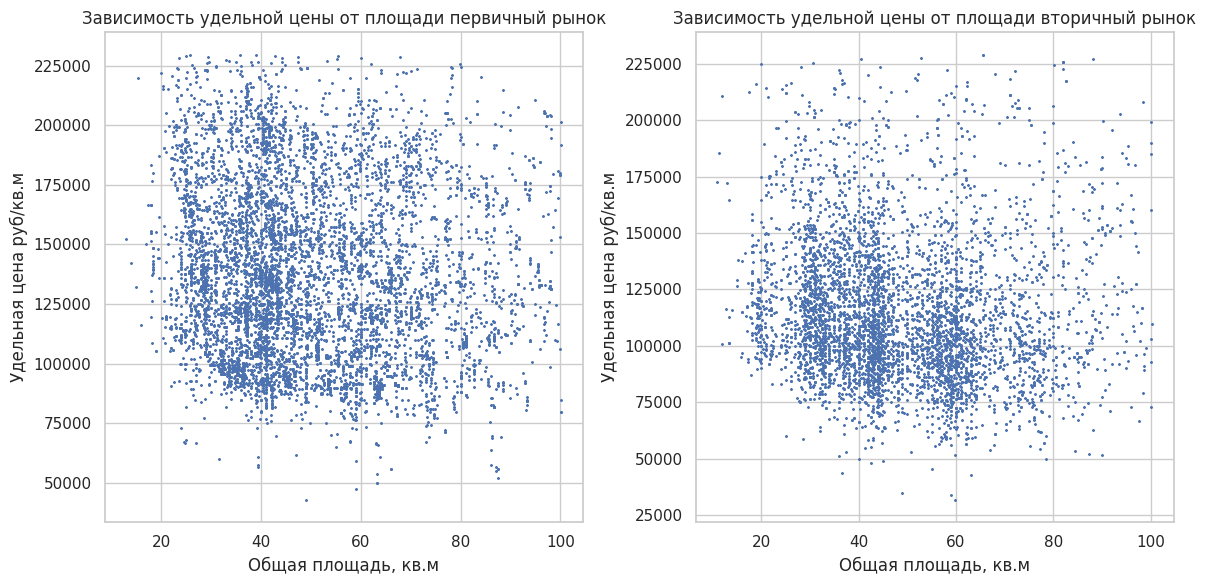

In [ ]:
# Выбираем данные по типам объектов
df_warehouse = df_no_outliers[df_no_outliers['Тип рынка'] == 'Первичный']
df_pp = df_no_outliers[df_no_outliers['Тип рынка'] == 'Вторичный']

plt.figure(figsize=(12, 6))

#Построение зависимости удельной цены от площади
plt.subplot(1, 2, 1)
plt.scatter(df_warehouse['Общая площадь, кв.м'], df_warehouse['Удельная цена руб/кв.м'], s=1, marker='X')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Удельная цена руб/кв.м')
plt.title('Зависимость удельной цены от площади первичный рынок')

plt.subplot(1, 2, 2)
plt.scatter(df_pp['Общая площадь, кв.м'], df_pp['Удельная цена руб/кв.м'], s=1, marker='X')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Удельная цена руб/кв.м')
plt.title('Зависимость удельной цены от площади вторичный рынок')

plt.tight_layout()
plt.show()

Заметно, что основная масса данных для первичного рынка распределена между отметками 75000 и 200000, когда вторичный рынок не доходит до 175000

### Задача 2: Анализ параметров

In [ ]:
for feature in non_numeric_features:
    # Группировка данных по категории
    grouped_data = df_no_outliers.groupby(feature)
    # Вычисление среднего, медианы, максимума и минимума удельной цены в каждой категории
    statistics = grouped_data['Удельная цена руб/кв.м'].agg(['mean', 'median', 'max', 'min'])
    print('Удельная цена руб/кв.м')
    print(statistics)

Удельная цена руб/кв.м
                                          mean      median        max  \
Ценовая зона                                                            
                                  98343.761701   95115.260  137500.00   
nan                              113534.263074   98647.125  228800.00   
Зеленая зона                     141220.488437  137959.025  205238.10   
Зона автомагистралей             174230.657773  178183.360  220621.34   
ИЖС                              137566.037500  131000.000  224938.70   
Исторический центр города        133389.732455  127272.730  229571.98   
Многоквартирная жилая застройка  125312.285339  119109.945  229487.17   
Окраины                          102727.811007  102446.733  183333.33   
Промзоны                         145928.177606  148133.080  225993.16   

                                       min  
Ценовая зона                                
                                 81694.914  
nan                              51839

Из средних значений по катеоргиям видно, что у вторичного рынка, удельная цена ниже чем у первичного рынка.

In [ ]:
# Создание кросс-таблицы для ценовых зон и классов
cross_tab = pd.crosstab(df_no_outliers['Ценовая зона'], df_no_outliers['Тип рынка'])
print(cross_tab)

Тип рынка                        Вторичный  Первичный
Ценовая зона                                         
                                         8         59
nan                                    104        627
Зеленая зона                            14         34
Зона автомагистралей                     7        235
ИЖС                                     36        628
Исторический центр города              740       2369
Многоквартирная жилая застройка       4342       2999
Окраины                                273        681
Промзоны                                35        645


### Задача 3: Построение моделей линейной регрессии

Я думаю, что качественное влияние на цену будут оказывать признаки: 'Ценовая зона', 'Тип рынка', 'Общая площадь, кв.м', 'Удельная цена руб/кв.м'

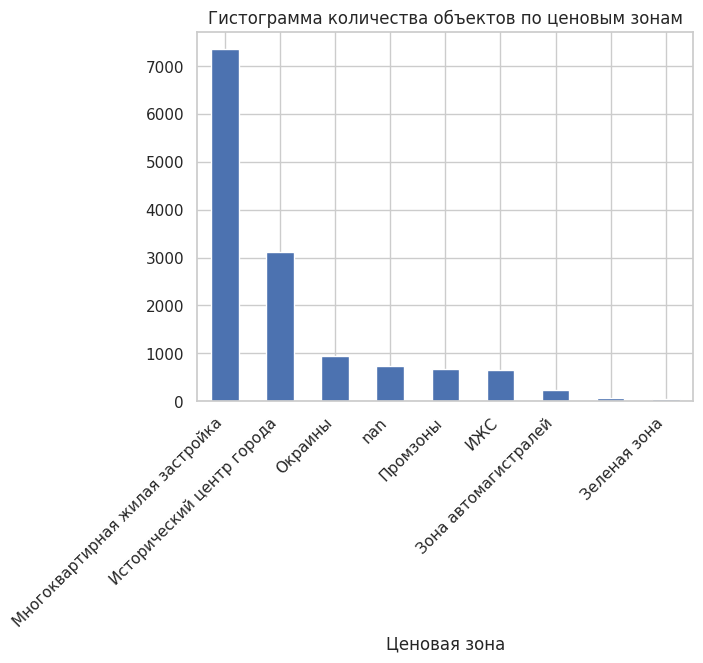

Ценовая зона
Многоквартирная жилая застройка    7341
Исторический центр города          3109
Окраины                             954
nan                                 731
Промзоны                            680
ИЖС                                 664
Зона автомагистралей                242
                                     67
Зеленая зона                         48
Name: count, dtype: int64


In [ ]:
df_no_outliers['Ценовая зона'].value_counts().plot(kind='bar')
plt.title('Гистограмма количества объектов по ценовым зонам')
plt.xticks(rotation=45, ha='right')
plt.show()

print(df_no_outliers['Ценовая зона'].value_counts())

Так как пустых значений очень много, оставим их как отдельный признак, так же добавим туда все зоны, встречающиеся реже 7%

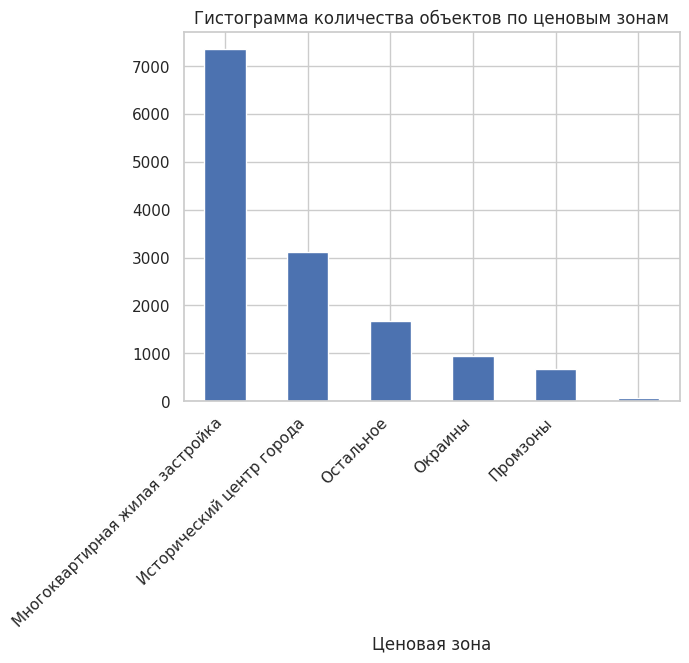

Ценовая зона
Многоквартирная жилая застройка    7341
Исторический центр города          3109
Остальное                          1685
Окраины                             954
Промзоны                            680
                                     67
Name: count, dtype: int64


In [ ]:
values_to_replace = ['nan', 'ИЖС', 'Зона автомагистралей', 'Центры деловой активности', 'Зеленая зона']
df_no_outliers['Ценовая зона'] = df_no_outliers['Ценовая зона'].replace(values_to_replace, 'Остальное')
df_no_outliers['Ценовая зона'].value_counts().plot(kind='bar')
plt.title('Гистограмма количества объектов по ценовым зонам')
plt.xticks(rotation=45, ha='right')
plt.show()
print(df_no_outliers['Ценовая зона'].value_counts())

Теперь можно закодировать параметры и построить модель линейной регрессии

In [ ]:
def mdape(y_true, y_pred):
    """
    Вычисляет Median Absolute Percentage Error (MdAPE).

    Параметры:
    - y_true: фактические значения
    - y_pred: предсказанные значения
    """
    error = np.abs((y_true - y_pred) / y_true) * 100
    return np.median(error)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

dft = df_no_outliers
# Применить логарифм к удельной цене
# dft['Удельная цена руб/кв.м'] = np.log1p(dft['Удельная цена руб/кв.м'])
dft = dft.drop(columns = 'Жилая площадь, кв.м')
dft = dft.drop(columns = 'Площадь кухни, кв.м')
dft = dft.drop(columns = 'Год постройки')
dft = dft.dropna(subset=['Этажей_'])
X = dft.drop('Удельная цена руб/кв.м', axis=1)
y = dft['Удельная цена руб/кв.м']
print(X.columns)
pd.options.display.float_format = '{:.3f}'.format
# Разделяем данные на обучающую и тестовую выборки (75% и 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Заменить классы на среднее значение удельной цены в классе
#class_means_train = dft.groupby('Тип рынка')['Удельная цена руб/кв.м'].mean()
#X_train['Тип рынка'] = X_train['Тип рынка'].map(class_means_train)
#X_test['Тип рынка'] = X_test['Тип рынка'].map(class_means_train)

# Создать интервалы для площади и преобразовать ее в категориальный признак
#bins = [0, 100, 200, 2000, 6000, 135000]
#labels = ['Очень маленькие', 'Маленькие', 'Средние', 'Большие', 'Очень большие']
#X_train['Площадь интервал'] = pd.cut(X_train['Общая площадь, кв.м'], bins=bins, labels=labels)
#X_test['Площадь интервал'] = pd.cut(X_test['Общая площадь, кв.м'], bins=bins, labels=labels)

# Стандартизация числовых признаков
numeric_features = ['Расстояние до центра', 'Общая площадь, кв.м', 'Этажей_', 'Количество комнат'] # 'Цена, руб',
scaler = MinMaxScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Применить One-Hot Encoding для Категориальных признаков
#X_train = pd.get_dummies(X_train, columns=['Площадь интервал'], prefix='Площадь интервал')
X_train = pd.get_dummies(X_train, columns=['Ценовая зона'], prefix='Ценовая_зона')
X_train = pd.get_dummies(X_train, columns=['Тип рынка'], prefix='Тип_рынка')
#X_test = pd.get_dummies(X_test, columns=['Площадь интервал'], prefix='Площадь интервал')
X_test = pd.get_dummies(X_test, columns=['Ценовая зона'], prefix='Ценовая_зона')
X_test = pd.get_dummies(X_test, columns=['Тип рынка'], prefix='Тип_рынка')

print(X_train.columns)
#print(X_train.describe())
#print(y_train.describe())
#for i in numeric_features:
#    print((X_train[i].isnull()).value_counts())

Index(['Ценовая зона', 'Расстояние до центра', 'Тип рынка', 'Этажей_',
       'Количество комнат', 'Общая площадь, кв.м'],
      dtype='object')
Index(['Расстояние до центра', 'Этажей_', 'Количество комнат',
       'Общая площадь, кв.м', 'Ценовая_зона_',
       'Ценовая_зона_Исторический центр города',
       'Ценовая_зона_Многоквартирная жилая застройка', 'Ценовая_зона_Окраины',
       'Ценовая_зона_Остальное', 'Ценовая_зона_Промзоны',
       'Тип_рынка_Вторичный', 'Тип_рынка_Первичный'],
      dtype='object')


Применение логарифма к целевому признаку сильно уменьшает R-квадрат, не буду его использовать

In [ ]:
# Создаем и обучаем модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказываем значения для тестовой выборки
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mdape_l = mdape(y_test, y_pred)

# Вычисляем MdAPE для Liear Regression
mdape_linear = mdape(y_train, y_train_pred)

print(f'Median Absolute Percentage Error (MdAPE) на обучающих данных: {mdape_linear:.2f}%')
print(f'MdAPE для линейной регрессии: {mdape_l:.2f}%')
print(f'Среднеквадратическое отклонение: {mse:.2f}')
print(f'R-квадрат: {r2:.2f}')

Median Absolute Percentage Error (MdAPE) на обучающих данных: 15.49%
MdAPE для линейной регрессии: 15.25%
Среднеквадратическое отклонение: 866469425.92
R-квадрат: 0.30


Аналогично поступим для модели регрессии Лассо и Ридж

In [ ]:
# Lasso Regression
lasso_params = {'alpha': [0.5, 1, 2, 3, 5, 10, 25]}
lasso = Lasso()
lasso_grid = GridSearchCV(lasso, lasso_params, cv=7)
lasso_grid.fit(X_train, y_train)

# Ridge Regression
ridge_params = {'alpha': [0.1, 0.3, 0.5, 0.7, 1, 2, 3, 5, 10]}
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, cv=9)
ridge_grid.fit(X_train, y_train)

# Лучшие параметры
best_alpha_lasso = lasso_grid.best_params_['alpha']
best_alpha_ridge = ridge_grid.best_params_['alpha']

In [ ]:
# Обучение моделей с лучшими параметрами
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)

ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)

# Стохастический градиентный спуск
sgd_model = SGDRegressor(alpha=best_alpha_ridge)
sgd_model.fit(X_train, y_train)

# Предсказываем значения для тестовой выборки
y_pred_lasso = lasso_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_sgd = sgd_model.predict(X_test)

# Оценка производительности моделей
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
mdape_las = mdape(y_train, lasso_model.predict(X_train))

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
mdape_rid = mdape(y_train, ridge_model.predict(X_train))

mse_sgd = mean_squared_error(y_test, y_pred_sgd)
r2_sgd = r2_score(y_test, y_pred_sgd)
mdape_sgd = mdape(y_train, sgd_model.predict(X_train))

print("Best Alpha for Lasso:", best_alpha_lasso)
print("Best Alpha for Ridge:", best_alpha_ridge)

print("\nЛассо регрессия:")
print(f'Среднеквадратическое отклонение: {mse_lasso:.2f}')
print(f'R-квадрат: {r2_lasso:.2f}')
print(f'MdAPE на обучающих данных: {mdape_las:.2f}%')

print("\nРидж регрессия:")
print(f'Среднеквадратическое отклонение: {mse_ridge:.2f}')
print(f'R-квадрат: {r2_ridge:.2f}')
print(f'MdAPE на обучающих данных: {mdape_rid:.2f}%')

print("\nСтохастический градиентный спуск:")
print(f'Среднеквадратическое отклонение: {mse_sgd:.2f}')
print(f'R-квадрат: {r2_sgd:.2f}')
print(f'MdAPE на обучающих данных: {mdape_sgd:.2f}%')

Best Alpha for Lasso: 0.5
Best Alpha for Ridge: 1

Лассо регрессия:
Среднеквадратическое отклонение: 865485210.78
R-квадрат: 0.30
MdAPE на обучающих данных: 15.48%

Ридж регрессия:
Среднеквадратическое отклонение: 865695921.13
R-квадрат: 0.30
MdAPE на обучающих данных: 15.49%

Стохастический градиентный спуск:
Среднеквадратическое отклонение: 1153613901.65
R-квадрат: 0.07
MdAPE на обучающих данных: 20.33%


Сравним модели

In [ ]:
# Вычисляем MdAPE
mdape_lasso = mdape(y_test, y_pred_lasso)
mdape_ridge = mdape(y_test, y_pred_ridge)
mdape_linear = mdape(y_test, y_pred)

print(f'MdAPE для линейной регрессии: {mdape_linear:.2f}%')
print(f'MdAPE для Лассо регрессии: {mdape_lasso:.2f}%')
print(f'MdAPE для Ридж регрессии: {mdape_ridge:.2f}%')

MdAPE для линейной регрессии: 15.25%
MdAPE для Лассо регрессии: 15.22%
MdAPE для Ридж регрессии: 15.23%


Лучшей моделью по признаку MdAPE оказалась линейная регрессия, но этот результат непостоянен из-за стохастической натуры метода

В ходе различных экспериментов я подобрал лучшие параметры для лассо и ридж регрессий, так же пришёл к текущему набору признаков

### Задача 4: KNN и Дерево принятия решений

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


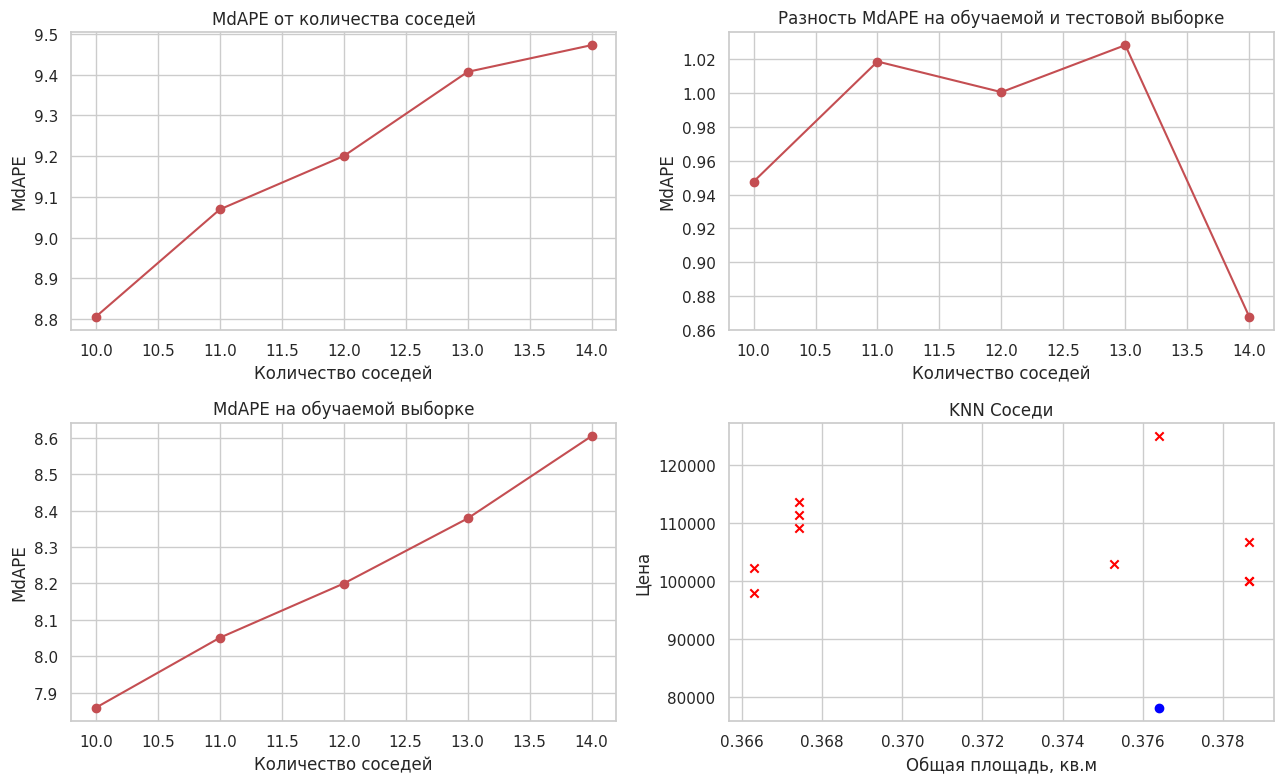


KNN для {'n_neighbors': 10} соседей
Лучшее количество соседей: {'n_neighbors': 10}
Среднеквадратическое отклонение: 508400682.25
R-квадрат: 0.59
MdAPE на обучающих данных: 7.53%
MdAPE на тестовых данных: 8.77%


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
# Зададим диапазон значений для параметра n_neighbors
param_grid = {'n_neighbors': np.arange(10, 15)
              }

# Определим метрику для использования в GridSearchCV
scorer = make_scorer(mdape, greater_is_better=False)
knn_model = KNeighborsRegressor(weights='uniform', p=2)

# Создадим объект GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, scoring=scorer, refit=True, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

# Найдём лучшие параметры
best_n_neighbors = grid_search.best_params_

# Построим график зависимости MdAPE от количества соседей
results = grid_search.cv_results_
#print(results)

fig, axs = plt.subplots(2, 2, figsize=(13, 8))
ax = axs[0, 0]
plt.sca(ax)
plt.plot(results['param_n_neighbors'], -results['mean_test_score'], marker='o', color = 'r')
plt.title('MdAPE от количества соседей')
plt.xlabel('Количество соседей')
plt.ylabel('MdAPE')

ax = axs[1, 0]
plt.sca(ax)
plt.plot(results['param_n_neighbors'], -results['mean_train_score'], marker='o', color = 'r')
plt.title('MdAPE на обучаемой выборке')
plt.xlabel('Количество соседей')
plt.ylabel('MdAPE')


ax = axs[0, 1]
plt.sca(ax)
plt.plot(results['param_n_neighbors'], -results['mean_test_score'] + results['mean_train_score'], marker='o', color = 'r')
plt.title('Разность MdAPE на обучаемой и тестовой выборке')
plt.xlabel('Количество соседей')
plt.ylabel('MdAPE')

# Предсказание значений для тестовой выборки
best_knn_model = KNeighborsRegressor(n_neighbors=best_n_neighbors['n_neighbors'])
best_knn_model.fit(X_train, y_train)
y_pred_knn = best_knn_model.predict(X_test)

# Выберем несколько точек из тестовой выборки для визуализации соседей
num_points_to_visualize = 1
selected_points_indices = np.random.choice(X_test.shape[1], num_points_to_visualize, replace=False)
selected_points = X_test.iloc[selected_points_indices].to_numpy()

# Получим индексы ближайших соседей для выбранных точек
distances, k_neighbors_indices = best_knn_model.kneighbors(selected_points)
ax = axs[1, 1]
plt.sca(ax)
col = 3
# Визуализация выбранных точек и их соседей
for i in range(num_points_to_visualize):
    # Визуализация выбранной точки
    plt.scatter(selected_points[i, col], y_test.iloc[selected_points_indices[i]], color='blue', marker='o')
    # Визуализация соседей
    plt.scatter(X_train.iloc[k_neighbors_indices[i], col], y_train.iloc[k_neighbors_indices[i]], color='red', marker='x')
plt.title(f'KNN Соседи')
plt.xlabel(f'{X_train.columns[col]}')
plt.ylabel(f'Цена')
plt.tight_layout()
plt.show()

# Оценка производительности модели k-nn
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
mdape_knn = mdape(y_train, best_knn_model.predict(X_train))
mdape_knn_test = mdape(y_test, best_knn_model.predict(X_test))

print(f'\nKNN для {best_n_neighbors} соседей')
print("Лучшее количество соседей:", best_n_neighbors)
print(f'Среднеквадратическое отклонение: {mse_knn:.2f}')
print(f'R-квадрат: {r2_knn:.2f}')
print(f'MdAPE на обучающих данных: {mdape_knn:.2f}%')
print(f'MdAPE на тестовых данных: {mdape_knn_test:.2f}%')

Первый сосед - сам объект, он вносит наибольшее влияние, поэтому на маленьких количествах соседей происходит переобучение

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


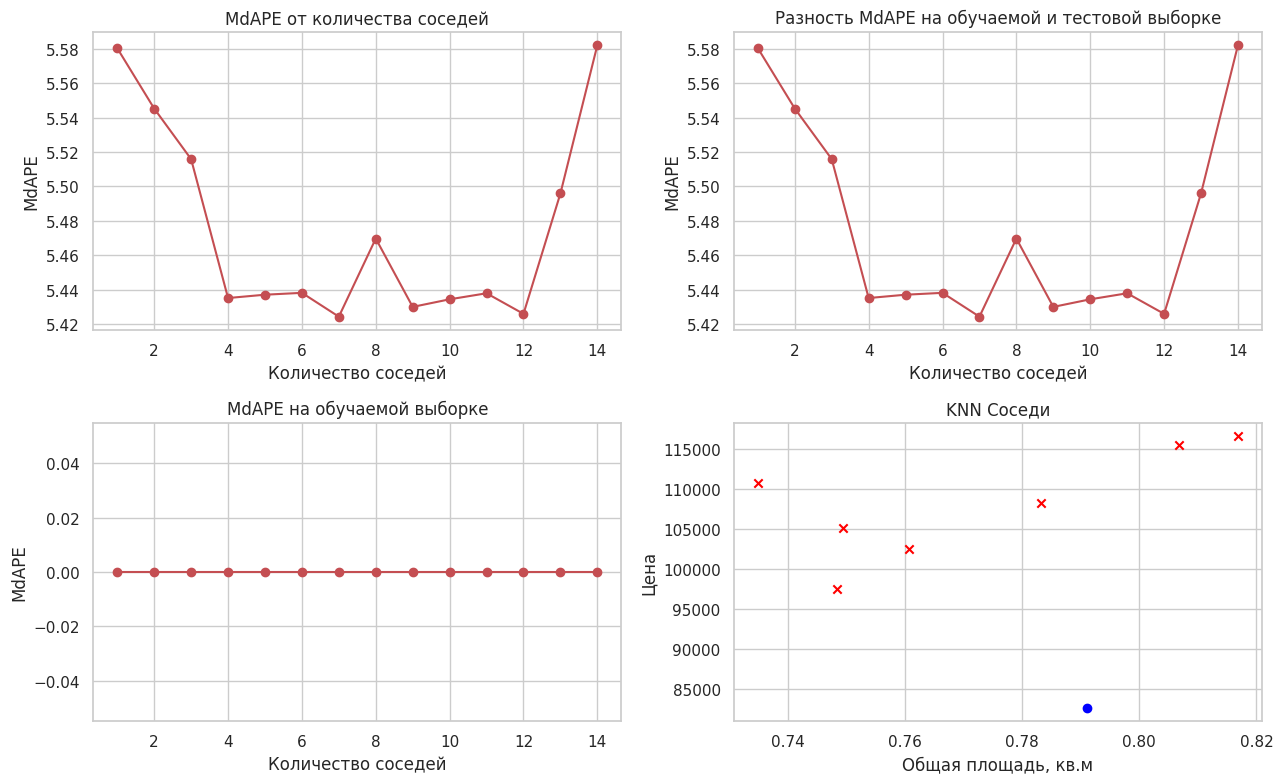


KNN для {'n_neighbors': 7} соседей
Лучшее количество соседей: {'n_neighbors': 7}
Среднеквадратическое отклонение: 502480749.27
R-квадрат: 0.60
MdAPE на обучающих данных: 6.63%
MdAPE на тестовых данных: 8.16%


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
# Зададим диапазон значений для параметра n_neighbors
param_grid = {'n_neighbors': np.arange(1, 15)
              }

# Определим метрику для использования в GridSearchCV
scorer = make_scorer(mdape, greater_is_better=False)
knn_model = KNeighborsRegressor(weights='distance', p=2)

# Создадим объект GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, scoring=scorer, refit=True, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train )

# Найдём лучшие параметры
best_n_neighbors = grid_search.best_params_

# Построим график зависимости MdAPE от количества соседей
results = grid_search.cv_results_
#print(results)

fig, axs = plt.subplots(2, 2, figsize=(13, 8))
ax = axs[0, 0]
plt.sca(ax)
plt.plot(results['param_n_neighbors'], -results['mean_test_score'], marker='o', color = 'r')
plt.title('MdAPE от количества соседей')
plt.xlabel('Количество соседей')
plt.ylabel('MdAPE')

ax = axs[1, 0]
plt.sca(ax)
plt.plot(results['param_n_neighbors'], -results['mean_train_score'], marker='o', color = 'r')
plt.title('MdAPE на обучаемой выборке')
plt.xlabel('Количество соседей')
plt.ylabel('MdAPE')


ax = axs[0, 1]
plt.sca(ax)
plt.plot(results['param_n_neighbors'], -results['mean_test_score'] + results['mean_train_score'], marker='o', color = 'r')
plt.title('Разность MdAPE на обучаемой и тестовой выборке')
plt.xlabel('Количество соседей')
plt.ylabel('MdAPE')

# Предсказание значений для тестовой выборки
best_knn_model = KNeighborsRegressor(n_neighbors=best_n_neighbors['n_neighbors'])
best_knn_model.fit(X_train, y_train)
y_pred_knn = best_knn_model.predict(X_test)

# Выберем несколько точек из тестовой выборки для визуализации соседей
num_points_to_visualize = 1
selected_points_indices = np.random.choice(X_test.shape[1], num_points_to_visualize, replace=False)
selected_points = X_test.iloc[selected_points_indices].to_numpy()

# Получим индексы ближайших соседей для выбранных точек
distances, k_neighbors_indices = best_knn_model.kneighbors(selected_points)
ax = axs[1, 1]
plt.sca(ax)
col = 3
# Визуализация выбранных точек и их соседей
for i in range(num_points_to_visualize):
    # Визуализация выбранной точки
    plt.scatter(selected_points[i, col], y_test.iloc[selected_points_indices[i]], color='blue', marker='o')
    # Визуализация соседей
    plt.scatter(X_train.iloc[k_neighbors_indices[i], col], y_train.iloc[k_neighbors_indices[i]], color='red', marker='x')
plt.title(f'KNN Соседи')
plt.xlabel(f'{X_train.columns[col]}')
plt.ylabel(f'Цена')
plt.tight_layout()
plt.show()

# Оценка производительности модели k-nn
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
mdape_knn = mdape(y_train, best_knn_model.predict(X_train))
mdape_knn_test = mdape(y_test, best_knn_model.predict(X_test))

print(f'\nKNN для {best_n_neighbors} соседей')
print("Лучшее количество соседей:", best_n_neighbors)
print(f'Среднеквадратическое отклонение: {mse_knn:.2f}')
print(f'R-квадрат: {r2_knn:.2f}')
print(f'MdAPE на обучающих данных: {mdape_knn:.2f}%')
print(f'MdAPE на тестовых данных: {mdape_knn_test:.2f}%')

Явно переобучение

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Параметры для подбора
param_grid = {
#    'max_depth': [5, 7, 9, 10, 18, 20, 23, 27],
    'max_depth': [5, 7, 9, 10],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 3, 6, 9]
}

# Определим метрику для использования в GridSearchCV
scorer = make_scorer(mdape, greater_is_better=False)

# Создание модели дерева решений
tree_model = DecisionTreeRegressor(random_state=42)

# Инициализация GridSearchCV
grid_search = GridSearchCV(tree_model, param_grid, scoring=scorer, cv=5, return_train_score = True)

# Подгонка модели
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров
best_params_tree = grid_search.best_params_

# Предсказание значений для тестовой выборки с лучшими параметрами
y_pred_tree_cv = grid_search.predict(X_test)

# Оценка производительности модели дерева решений с лучшими параметрами
mse_tree_cv = mean_squared_error(y_test, y_pred_tree_cv)
r2_tree_cv = r2_score(y_test, y_pred_tree_cv)
mdape_tree_cv = mdape(y_train, grid_search.predict(X_train))
mdape_tree_test = mdape(y_test, y_pred_tree_cv)

print("Дерево решений с кросс-валидацией:")
print(f'Лучшие параметры: {best_params_tree}')
print(f'Среднеквадратическое отклонение: {mse_tree_cv:.2f}')
print(f'R-квадрат: {r2_tree_cv:.2f}')
print(f'MdAPE на обучающих данных: {mdape_tree_cv:.2f}%')
print(f'MdAPE для дерева принятия решений: {mdape_tree_test:.2f}%')

Дерево решений с кросс-валидацией:
Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Среднеквадратическое отклонение: 442229835.49
R-квадрат: 0.64
MdAPE на обучающих данных: 7.01%
MdAPE для дерева принятия решений: 8.20%


In [ ]:
# Функция для построения графика зависимости MdAPE от параметра
def plot_dependency(param_values, param_name, fancy_name):
    params = {
        'max_depth': [best_params_tree['max_depth']],
        'min_samples_split': [best_params_tree['min_samples_split']],
        'min_samples_leaf': [best_params_tree['min_samples_leaf']]
    }
    params[param_name] = param_values
    grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), params, scoring=scorer, cv=5, return_train_score = True)
    grid_search_cv.fit(X_train, y_train)
    mdape_values = -grid_search_cv.cv_results_ ['mean_test_score']
    plt.plot(param_values, mdape_values, marker='o', linestyle='-')
    plt.title(f'Зависимость MdAPE  от параметра \'{fancy_name}\'')
    plt.xlabel(fancy_name)
    plt.ylabel('MdAPE (%)')
    plt.grid(True)

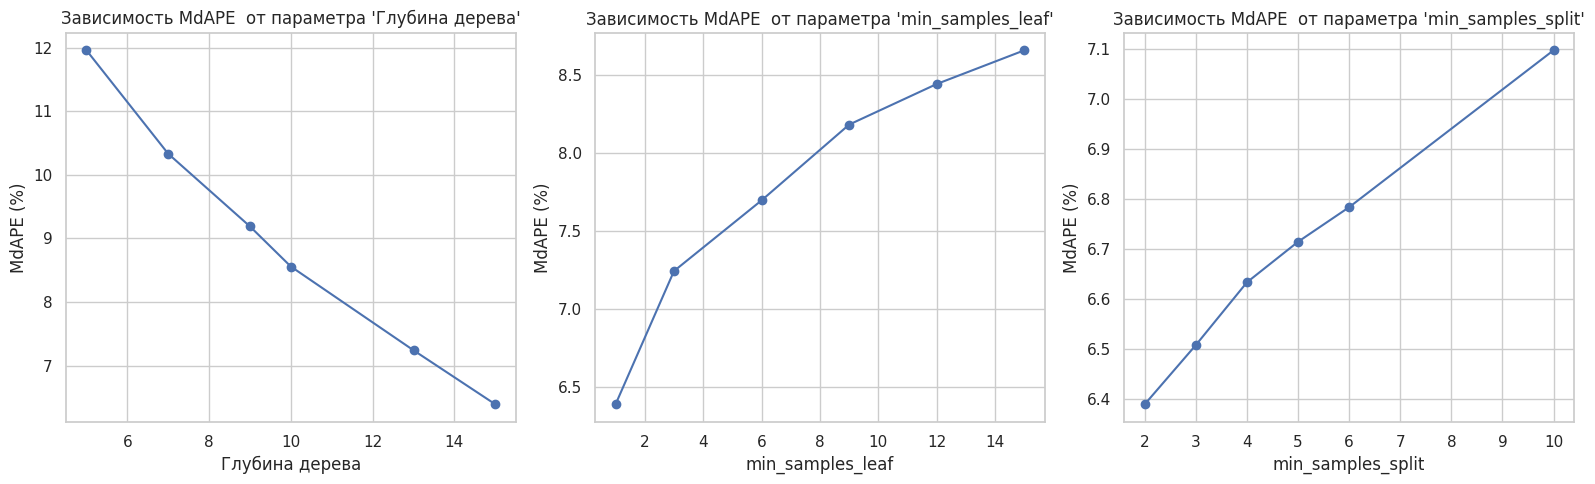

In [ ]:
# Инициализация параметров для построения графиков
depth_values = param_grid['max_depth']
min_samples_leaf_values = param_grid['min_samples_leaf']
min_samples_split_values = param_grid['min_samples_split']

# Построение графика зависимости от max_depth
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
ax = axs[0]
plt.sca(ax)
plot_dependency(depth_values, 'max_depth', 'Глубина дерева')

# Построение графика зависимости от min_samples_leaf
ax = axs[1]
plt.sca(ax)
plot_dependency(min_samples_leaf_values, 'min_samples_leaf', 'min_samples_leaf')

# Построение графика зависимости от min_samples_split
ax = axs[2]
plt.sca(ax)
plot_dependency(min_samples_split_values, 'min_samples_split', 'min_samples_split')
plt.tight_layout()
plt.show()

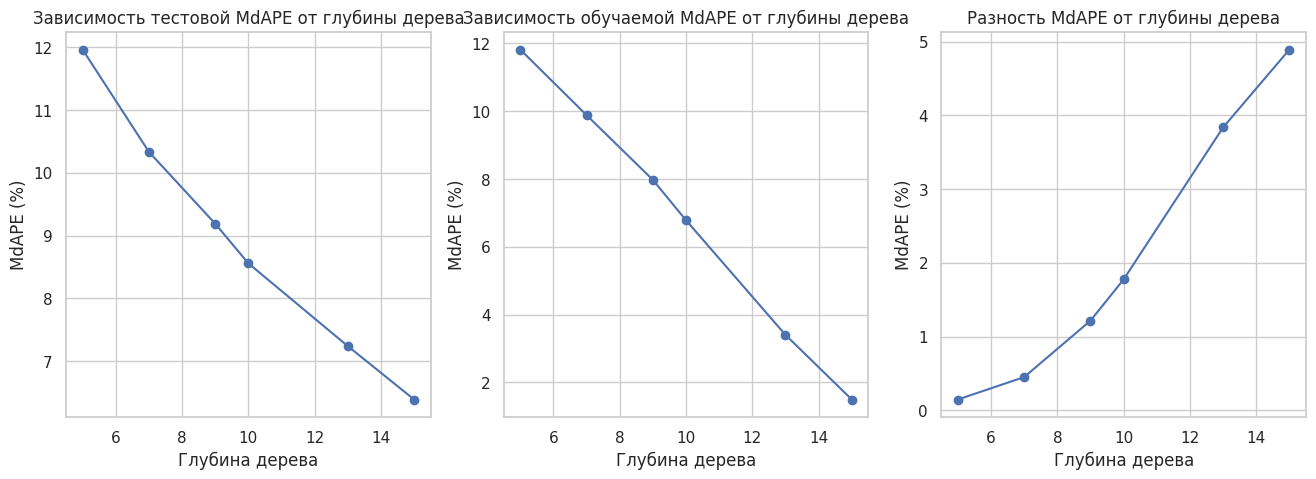

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
ax = axs[0]
plt.sca(ax)
params = {
        'max_depth': [best_params_tree['max_depth']],
        'min_samples_split': [best_params_tree['min_samples_split']],
        'min_samples_leaf': [best_params_tree['min_samples_leaf']]
    }
params['max_depth'] = depth_values
grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), params, scoring=scorer, cv=5, return_train_score = True)
grid_search_cv.fit(X_train, y_train)
mdape_values = -grid_search_cv.cv_results_ ['mean_test_score']
plt.plot(depth_values, mdape_values, marker='o', linestyle='-')
plt.title(f'Зависимость тестовой MdAPE от глубины дерева')
plt.xlabel('Глубина дерева')
plt.ylabel('MdAPE (%)')
plt.grid(True)

ax = axs[1]
plt.sca(ax)
params = {
        'max_depth': [best_params_tree['max_depth']],
        'min_samples_split': [best_params_tree['min_samples_split']],
        'min_samples_leaf': [best_params_tree['min_samples_leaf']]
    }
params['max_depth'] = depth_values
grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), params, scoring=scorer, cv=5, return_train_score = True)
grid_search_cv.fit(X_train, y_train)
mdape_values = -grid_search_cv.cv_results_ ['mean_train_score']
plt.plot(depth_values, mdape_values, marker='o', linestyle='-')
plt.title(f'Зависимость обучаемой MdAPE от глубины дерева')
plt.xlabel('Глубина дерева')
plt.ylabel('MdAPE (%)')
plt.grid(True)

ax = axs[2]
plt.sca(ax)
params = {
        'max_depth': [best_params_tree['max_depth']],
        'min_samples_split': [best_params_tree['min_samples_split']],
        'min_samples_leaf': [best_params_tree['min_samples_leaf']]
    }
params['max_depth'] = depth_values
grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), params, scoring=scorer, cv=5, return_train_score = True)
grid_search_cv.fit(X_train, y_train)
mdape_values = -grid_search_cv.cv_results_ ['mean_test_score'] + grid_search_cv.cv_results_ ['mean_train_score']
plt.plot(depth_values, mdape_values, marker='o', linestyle='-')
plt.title(f'Разность MdAPE от глубины дерева')
plt.xlabel('Глубина дерева')
plt.ylabel('MdAPE (%)')
plt.grid(True)

Text(0, 0.5, 'MdAPE (%)')

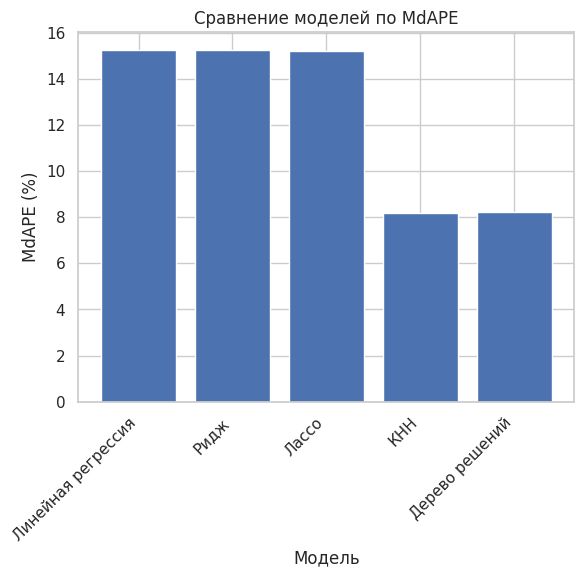

In [ ]:
plt.bar(['Линейная регрессия', 'Ридж', 'Лассо', 'КНН', 'Дерево решений'], [mdape_linear, mdape_ridge, mdape_lasso, mdape_knn_test, mdape_tree_test])
plt.title("Сравнение моделей по MdAPE")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Модель')
plt.ylabel('MdAPE (%)')

### Задача 5: Статистики

In [ ]:
df = data

columns_to_analyze = ['Удельная цена руб/кв.м', 'Общая площадь, кв.м']

# Задаем порог для определения выбросов
outlier_threshold = 1.5

# Создаем копию DataFrame, чтобы не изменять оригинал
df_no_outliers = df.copy()

# Удаляем строки с выбросами
for column in columns_to_analyze:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - outlier_threshold * iqr
    upper_bound = q3 + outlier_threshold * iqr

    df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]

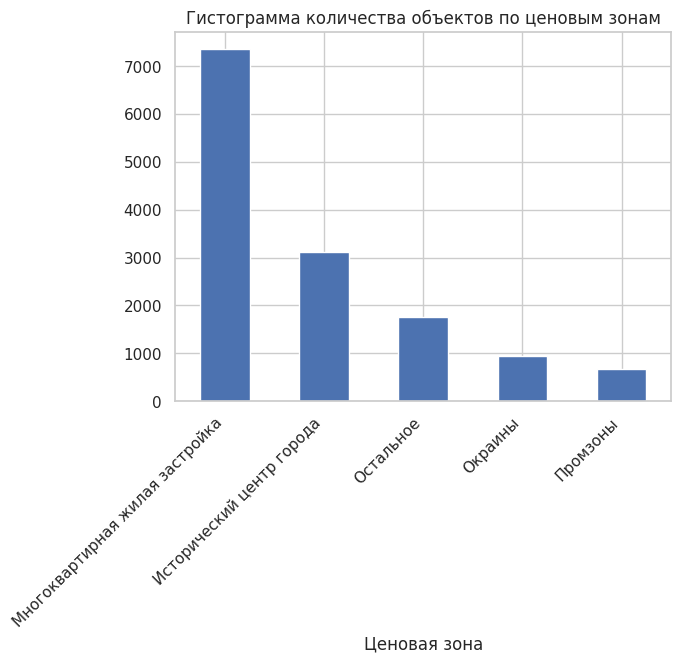

Ценовая зона
Многоквартирная жилая застройка    7341
Исторический центр города          3109
Остальное                          1752
Окраины                             954
Промзоны                            680
Name: count, dtype: int64


In [ ]:
values_to_replace = ['', 'nan', 'ИЖС', 'Зона автомагистралей', 'Центры деловой активности', 'Зеленая зона']
df_no_outliers['Ценовая зона'] = df_no_outliers['Ценовая зона'].replace(values_to_replace, 'Остальное')
df_no_outliers['Ценовая зона'].value_counts().plot(kind='bar')
plt.title('Гистограмма количества объектов по ценовым зонам')
plt.xticks(rotation=45, ha='right')
plt.show()
print(df_no_outliers['Ценовая зона'].value_counts())

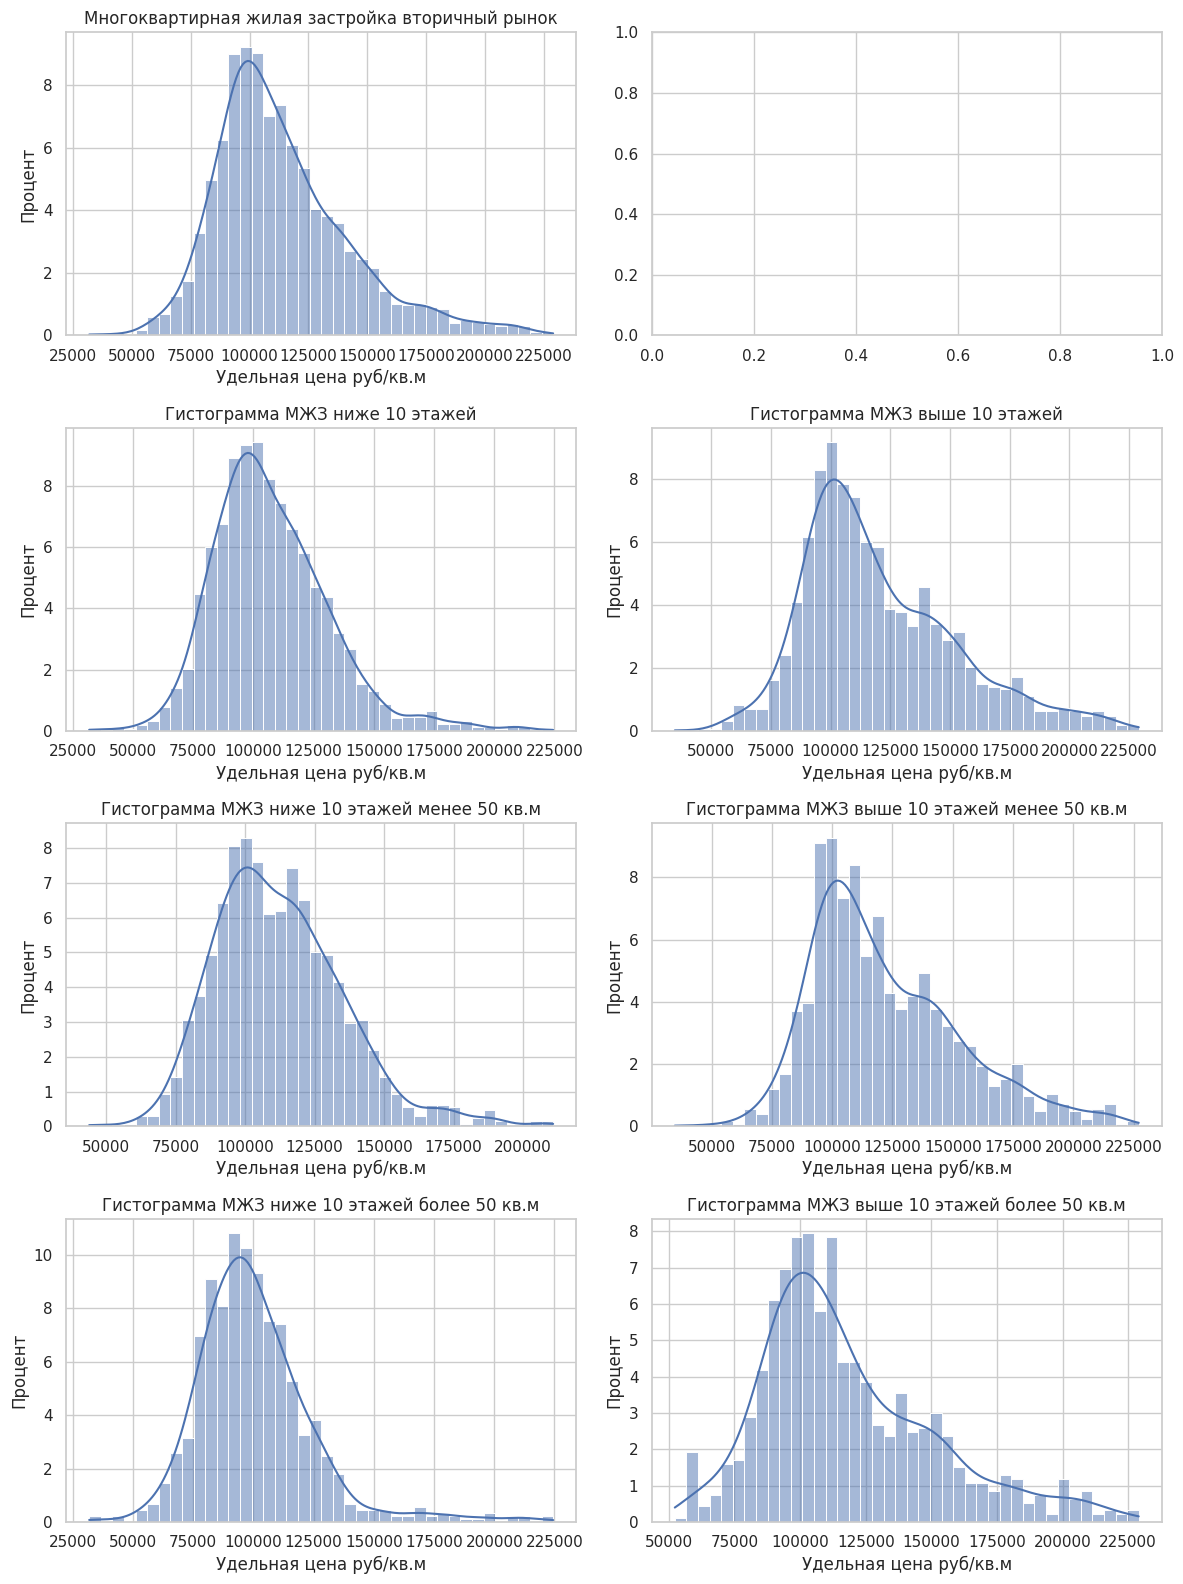

Для всей ценовой зоны: 
Количество: 4342.000, Среднее: 113987.980, Медиана: 108173.080, Дисперсия: 848363460.313, Ср. кв. отклонение:  29126.680
Для элементов выборки выше 10 этажей: 
Количество: 2173.000, Среднее: 120488.988, Медиана: 112565.445, Дисперсия: 1022146283.275, Ср. кв. отклонение:  31971.023
Для элементов выборки выше 10 этажей и площадью более 50 кв.м: 
Количество: 932.000, Среднее: 118433.732, Медиана: 110939.297, Дисперсия: 1121646473.765, Ср. кв. отклонение:  33490.991
Для элементов выборки выше 10 этажей и площадью менее 50 кв.м: 
Количество: 1241.000, Среднее: 122032.501, Медиана: 114111.380, Дисперсия: 941866173.576, Ср. кв. отклонение:  30689.838
Для элементов выборки ниже 10 этажей: 
Количество: 2168.000, Среднее: 107495.006, Медиана: 104133.804, Дисперсия: 588902170.600, Ср. кв. отклонение:  24267.307
Для элементов выборки ниже 10 этажей и площадью менее 50 кв.м: 
Количество: 1279.000, Среднее: 112305.200, Медиана: 109442.060, Дисперсия: 539110349.928, Ср. кв. от

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
feat = 'Удельная цена руб/кв.м'
zone = 'Многоквартирная жилая застройка'
zs = 'МЖЗ'
subdiv_stories = 10
subdiv_space = 50
i = 0
ax = axs[i // 2, i % 2]
#df_MZhS_all = df_no_outliers
df_MZhS_all = df_no_outliers[df_no_outliers['Ценовая зона'] == zone]
df_MZhS = df_MZhS_all[df_MZhS_all['Тип рынка'] == 'Вторичный']
#df_MZhS = df_MZhS_all[df_MZhS_all['Тип рынка'] == 'Первичный']
#df_MZhS = df_MZhS_all
sns.histplot(data = df_MZhS, x = feat, bins = 40, stat = 'percent', kde = True, ax = ax)
ax.set_title(f'{zone} вторичный рынок')
ax.set_xlabel(feat)
ax.set_ylabel('Процент')
i += 2
ax = axs[i // 2, i % 2]
df_MZhS_l10 = df_MZhS[df_MZhS['Этажей_'] < subdiv_stories]
sns.histplot(data = df_MZhS_l10, x = feat, bins = 40, stat = 'percent', kde = True, ax = ax)
ax.set_title(f'Гистограмма {zs} ниже {subdiv_stories} этажей')
ax.set_xlabel(feat)
ax.set_ylabel('Процент')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10 = df_MZhS[df_MZhS['Этажей_'] >= subdiv_stories]
sns.histplot(data = df_MZhS_m10, x = feat, bins = 40, stat = 'percent', kde = True, ax = ax)
ax.set_title(f'Гистограмма {zs} выше {subdiv_stories} этажей')
ax.set_xlabel(feat)
ax.set_ylabel('Процент')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_l10_Sl50 = df_MZhS_l10[df_MZhS_l10['Общая площадь, кв.м'] < subdiv_space]
sns.histplot(data = df_MZhS_l10_Sl50, x = feat, bins = 40, stat = 'percent', kde = True, ax = ax)
ax.set_title(f'Гистограмма {zs} ниже {subdiv_stories} этажей менее {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Процент')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10_Sl50 = df_MZhS_m10[df_MZhS_m10['Общая площадь, кв.м'] < subdiv_space]
sns.histplot(data = df_MZhS_m10_Sl50, x = feat, bins = 40, stat = 'percent', kde = True, ax = ax)
ax.set_title(f'Гистограмма {zs} выше {subdiv_stories} этажей менее {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Процент')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_l10_Sm50 = df_MZhS_l10[df_MZhS_l10['Общая площадь, кв.м'] >= subdiv_space]
sns.histplot(data = df_MZhS_l10_Sm50, x = feat, bins = 40, stat = 'percent', kde = True, ax = ax)
ax.set_title(f'Гистограмма {zs} ниже {subdiv_stories} этажей более {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Процент')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10_Sm50 = df_MZhS_m10[df_MZhS_m10['Общая площадь, кв.м'] >= subdiv_space]
sns.histplot(data = df_MZhS_m10_Sm50, x = feat, bins = 40, stat = 'percent', kde = True, ax = ax)
ax.set_title(f'Гистограмма {zs} выше {subdiv_stories} этажей более {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Процент')
plt.tight_layout()
plt.show()


print(f'Для всей ценовой зоны: ')
print(f'Количество: {(df_MZhS[feat].shape[0]):.3f}, Среднее: {np.mean(df_MZhS[feat]):.3f}, Медиана: {np.median(df_MZhS[feat]):.3f}, Дисперсия: {np.var(df_MZhS[feat]):.3f}, Ср. кв. отклонение:  {np.sqrt(np.var(df_MZhS[feat])):.3f}')

print(f'Для элементов выборки выше {subdiv_stories} этажей: ')
print(f'Количество: {(df_MZhS_m10[feat].shape[0]):.3f}, Среднее: {np.mean(df_MZhS_m10[feat]):.3f}, Медиана: {np.median(df_MZhS_m10[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10[feat]):.3f}, Ср. кв. отклонение:  {np.sqrt(np.var(df_MZhS_m10[feat])):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей и площадью более {subdiv_space} кв.м: ')
print(f'Количество: {(df_MZhS_m10_Sm50[feat].shape[0]):.3f}, Среднее: {np.mean(df_MZhS_m10_Sm50[feat]):.3f}, Медиана: {np.median(df_MZhS_m10_Sm50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10_Sm50[feat]):.3f}, Ср. кв. отклонение:  {np.sqrt(np.var(df_MZhS_m10_Sm50[feat])):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей и площадью менее {subdiv_space} кв.м: ')
print(f'Количество: {(df_MZhS_m10_Sl50[feat].shape[0]):.3f}, Среднее: {np.mean(df_MZhS_m10_Sl50[feat]):.3f}, Медиана: {np.median(df_MZhS_m10_Sl50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10_Sl50[feat]):.3f}, Ср. кв. отклонение:  {np.sqrt(np.var(df_MZhS_m10_Sl50[feat])):.3f}')

print(f'Для элементов выборки ниже {subdiv_stories} этажей: ')
print(f'Количество: {(df_MZhS_l10[feat].shape[0]):.3f}, Среднее: {np.mean(df_MZhS_l10[feat]):.3f}, Медиана: {np.median(df_MZhS_l10[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10[feat]):.3f}, Ср. кв. отклонение:  {np.sqrt(np.var(df_MZhS_l10[feat])):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей и площадью менее {subdiv_space} кв.м: ')
print(f'Количество: {(df_MZhS_l10_Sl50[feat].shape[0]):.3f}, Среднее: {np.mean(df_MZhS_l10_Sl50[feat]):.3f}, Медиана: {np.median(df_MZhS_l10_Sl50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10_Sl50[feat]):.3f}, Ср. кв. отклонение:  {np.sqrt(np.var(df_MZhS_l10_Sl50[feat])):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей и площадью более {subdiv_space} кв.м: ')
print(f'Количество: {(df_MZhS_l10_Sm50[feat].shape[0]):.3f}, Среднее: {np.mean(df_MZhS_l10_Sm50[feat]):.3f}, Медиана: {np.median(df_MZhS_l10_Sm50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10_Sm50[feat]):.3f}, Ср. кв. отклонение:  {np.sqrt(np.var(df_MZhS_l10_Sm50[feat])):.3f}')

print(f'{(df_MZhS[feat].shape[0]):.3f}, {np.mean(df_MZhS[feat]):.3f}, {np.median(df_MZhS[feat]):.3f}, {np.var(df_MZhS[feat]):.3f}, {np.sqrt(np.var(df_MZhS[feat])):.3f}')
print(f'{(df_MZhS_m10[feat].shape[0]):.3f}, {np.mean(df_MZhS_m10[feat]):.3f}, {np.median(df_MZhS_m10[feat]):.3f}, {np.var(df_MZhS_m10[feat]):.3f}, {np.sqrt(np.var(df_MZhS_m10[feat])):.3f}')
print(f'{(df_MZhS_m10_Sm50[feat].shape[0]):.3f}, {np.mean(df_MZhS_m10_Sm50[feat]):.3f}, {np.median(df_MZhS_m10_Sm50[feat]):.3f}, {np.var(df_MZhS_m10_Sm50[feat]):.3f}, {np.sqrt(np.var(df_MZhS_m10_Sm50[feat])):.3f}')
print(f'{(df_MZhS_m10_Sl50[feat].shape[0]):.3f}, {np.mean(df_MZhS_m10_Sl50[feat]):.3f}, {np.median(df_MZhS_m10_Sl50[feat]):.3f}, {np.var(df_MZhS_m10_Sl50[feat]):.3f}, {np.sqrt(np.var(df_MZhS_m10_Sl50[feat])):.3f}')
print(f'{(df_MZhS_l10[feat].shape[0]):.3f}, {np.mean(df_MZhS_l10[feat]):.3f}, {np.median(df_MZhS_l10[feat]):.3f}, {np.var(df_MZhS_l10[feat]):.3f}, {np.sqrt(np.var(df_MZhS_l10[feat])):.3f}')
print(f'{(df_MZhS_l10_Sl50[feat].shape[0]):.3f}, {np.mean(df_MZhS_l10_Sl50[feat]):.3f}, {np.median(df_MZhS_l10_Sl50[feat]):.3f}, {np.var(df_MZhS_l10_Sl50[feat]):.3f}, {np.sqrt(np.var(df_MZhS_l10_Sl50[feat])):.3f}')
print(f'{(df_MZhS_l10_Sm50[feat].shape[0]):.3f}, {np.mean(df_MZhS_l10_Sm50[feat]):.3f}, {np.median(df_MZhS_l10_Sm50[feat]):.3f}, {np.var(df_MZhS_l10_Sm50[feat]):.3f}, {np.sqrt(np.var(df_MZhS_l10_Sm50[feat])):.3f}')

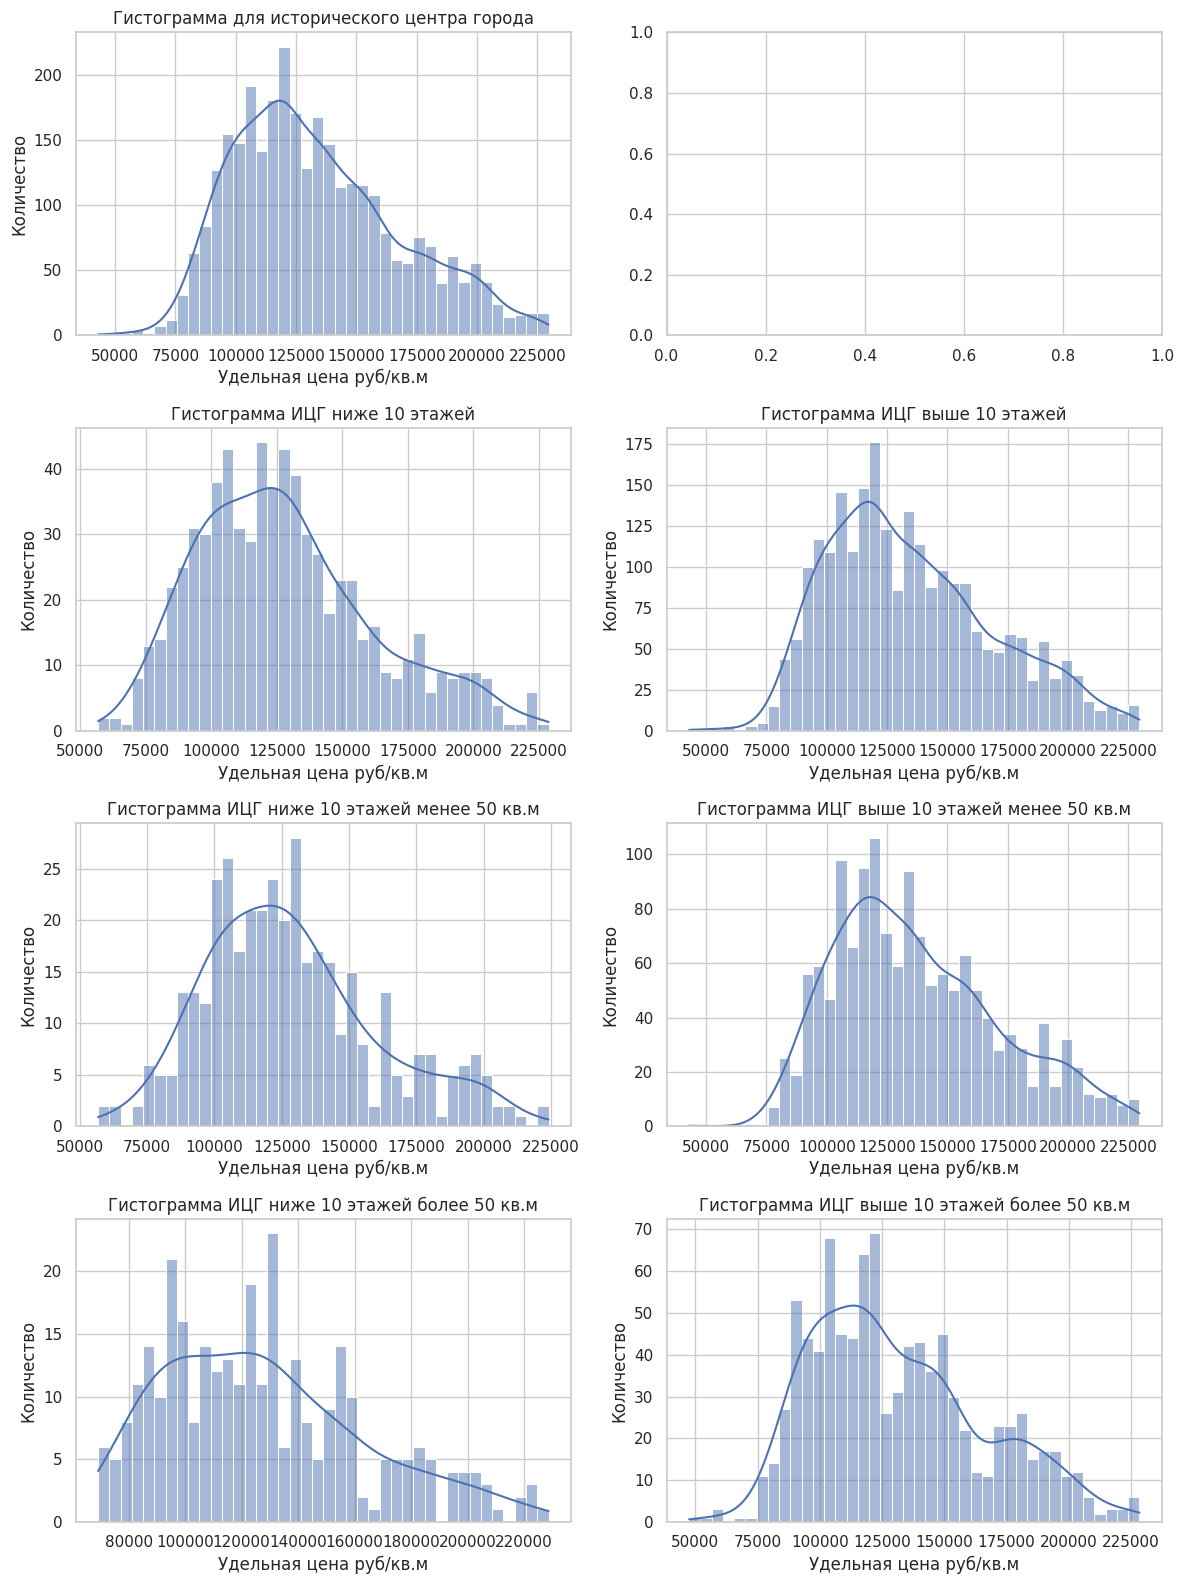

Для всей ценовой зоны: 
Среднее: 133389.732, Дисперсия: 1174464201.565
Для элементов выборки ниже 10 этажей: 
Среднее: 128101.500, Дисперсия: 1141672521.769
Для элементов выборки выше 10 этажей: 
Среднее: 134949.111, Дисперсия: 1173455697.885
Для элементов выборки ниже 10 этажей и площадью менее 50 кв.м: 
Среднее: 128512.325, Дисперсия: 1027543343.169
Для элементов выборки выше 10 этажей и площадью менее 50 кв.м: 
Среднее: 137414.638, Дисперсия: 1151970515.602
Для элементов выборки ниже 10 этажей и площадью более 50 кв.м: 
Среднее: 127597.658, Дисперсия: 1281181421.548
Для элементов выборки выше 10 этажей и площадью более 50 кв.м: 
Среднее: 131176.777, Дисперсия: 1182797407.264


In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
feat = 'Удельная цена руб/кв.м'
subdiv_stories = 10
subdiv_space = 50
i = 0
ax = axs[i // 2, i % 2]
df_MZhS = df_no_outliers[df_no_outliers['Ценовая зона'] == 'Исторический центр города']
sns.histplot(data = df_MZhS, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма для исторического центра города')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 2
ax = axs[i // 2, i % 2]
df_MZhS_l10 = df_MZhS[df_MZhS['Этажей_'] < subdiv_stories]
sns.histplot(data = df_MZhS_l10, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма ИЦГ ниже {subdiv_stories} этажей')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10 = df_MZhS[df_MZhS['Этажей_'] >= subdiv_stories]
sns.histplot(data = df_MZhS_m10, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма ИЦГ выше {subdiv_stories} этажей')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_l10_Sl50 = df_MZhS_l10[df_MZhS_l10['Общая площадь, кв.м'] < subdiv_space]
sns.histplot(data = df_MZhS_l10_Sl50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма ИЦГ ниже {subdiv_stories} этажей менее {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10_Sl50 = df_MZhS_m10[df_MZhS_m10['Общая площадь, кв.м'] < subdiv_space]
sns.histplot(data = df_MZhS_m10_Sl50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма ИЦГ выше {subdiv_stories} этажей менее {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_l10_Sm50 = df_MZhS_l10[df_MZhS_l10['Общая площадь, кв.м'] >= subdiv_space]
sns.histplot(data = df_MZhS_l10_Sm50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма ИЦГ ниже {subdiv_stories} этажей более {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10_Sm50 = df_MZhS_m10[df_MZhS_m10['Общая площадь, кв.м'] >= subdiv_space]
sns.histplot(data = df_MZhS_m10_Sm50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма ИЦГ выше {subdiv_stories} этажей более {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
plt.tight_layout()
plt.show()
print(f'Для всей ценовой зоны: ')
print(f'Среднее: {np.mean(df_MZhS[feat]):.3f}, Дисперсия: {np.var(df_MZhS[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей: ')
print(f'Среднее: {np.mean(df_MZhS_l10[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей: ')
print(f'Среднее: {np.mean(df_MZhS_m10[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей и площадью менее {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_l10_Sl50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10_Sl50[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей и площадью менее {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_m10_Sl50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10_Sl50[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей и площадью более {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_l10_Sm50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10_Sm50[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей и площадью более {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_m10_Sm50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10_Sm50[feat]):.3f}')

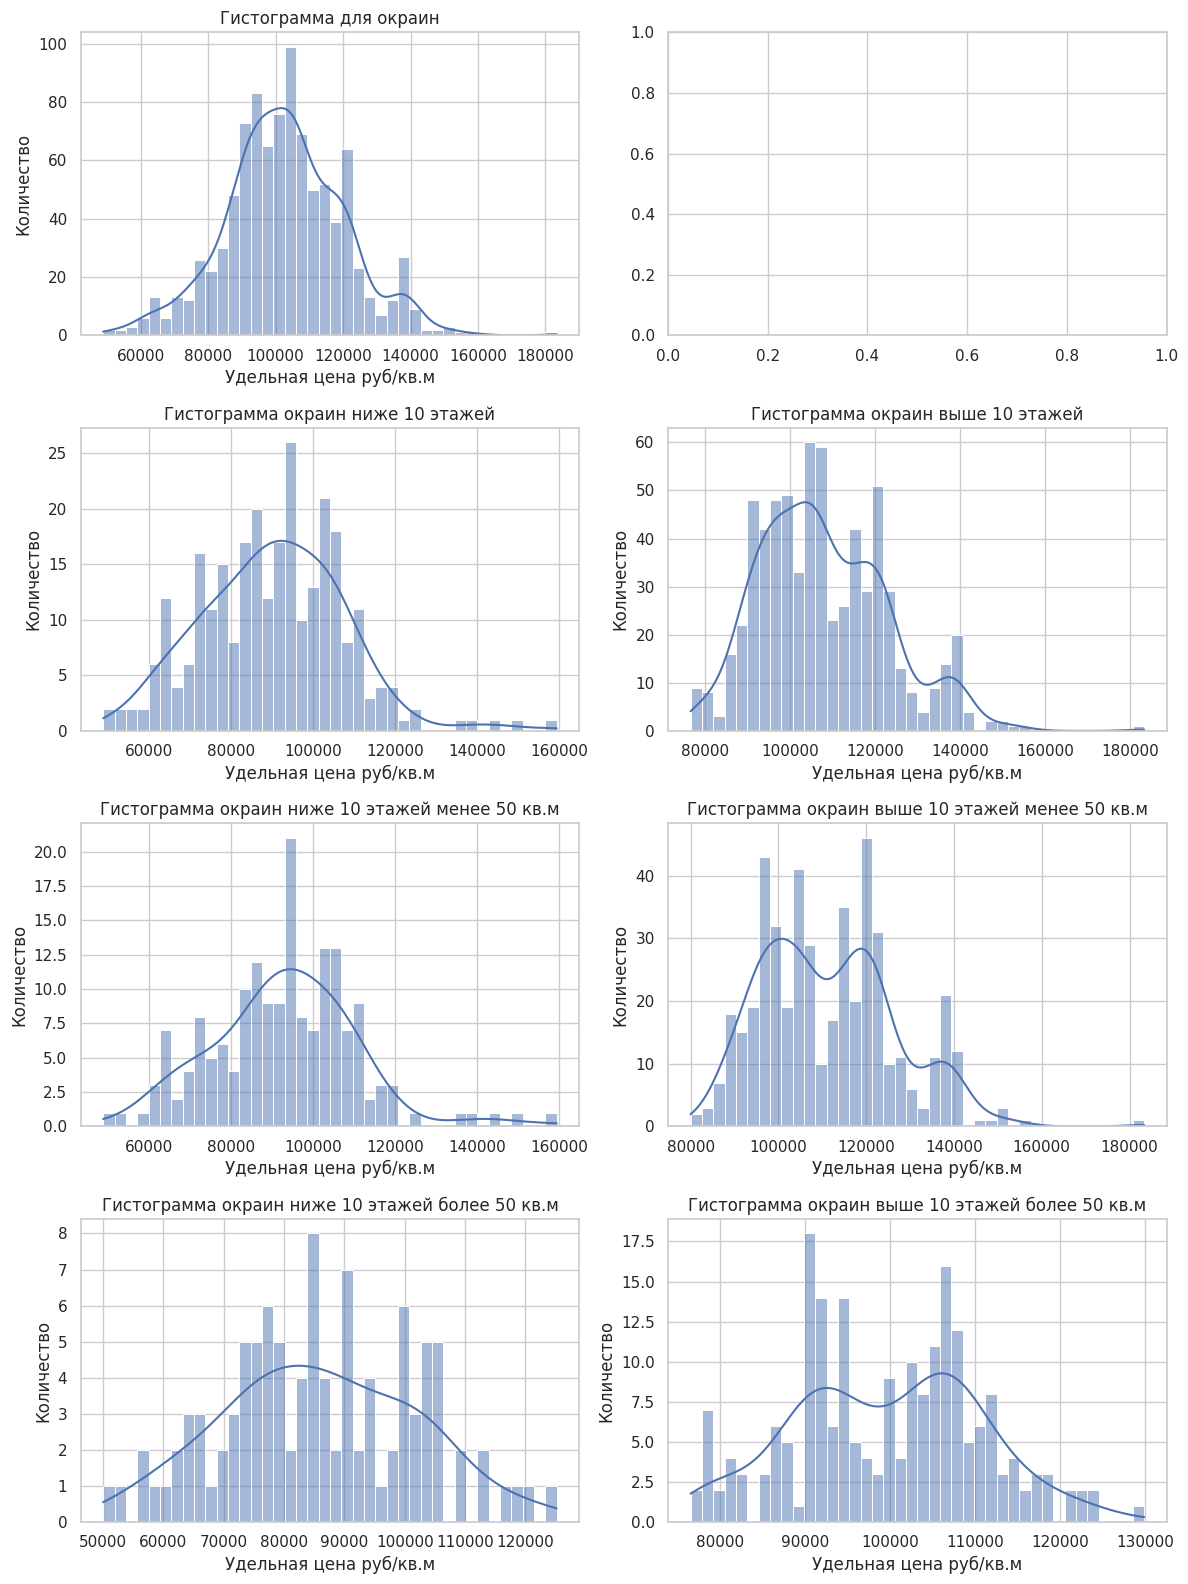

Для всей ценовой зоны: 
Среднее: 102727.811, Дисперсия: 313234271.054
Для элементов выборки ниже 10 этажей: 
Среднее: 90288.162, Дисперсия: 301564685.579
Для элементов выборки выше 10 этажей: 
Среднее: 107843.525, Дисперсия: 228225098.853
Для элементов выборки ниже 10 этажей и площадью менее 50 кв.м: 
Среднее: 92926.932, Дисперсия: 310466441.736
Для элементов выборки выше 10 этажей и площадью менее 50 кв.м: 
Среднее: 111485.553, Дисперсия: 232437153.800
Для элементов выборки ниже 10 этажей и площадью более 50 кв.м: 
Среднее: 85873.298, Дисперсия: 255530524.119
Для элементов выборки выше 10 этажей и площадью более 50 кв.м: 
Среднее: 99648.959, Дисперсия: 121752234.718


In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
feat = 'Удельная цена руб/кв.м'
subdiv_stories = 10
subdiv_space = 50
i = 0
ax = axs[i // 2, i % 2]
df_MZhS = df_no_outliers[df_no_outliers['Ценовая зона'] == 'Окраины']
sns.histplot(data = df_MZhS, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма для окраин')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 2
ax = axs[i // 2, i % 2]
df_MZhS_l10 = df_MZhS[df_MZhS['Этажей_'] < subdiv_stories]
sns.histplot(data = df_MZhS_l10, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма окраин ниже {subdiv_stories} этажей')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10 = df_MZhS[df_MZhS['Этажей_'] >= subdiv_stories]
sns.histplot(data = df_MZhS_m10, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма окраин выше {subdiv_stories} этажей')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_l10_Sl50 = df_MZhS_l10[df_MZhS_l10['Общая площадь, кв.м'] < subdiv_space]
sns.histplot(data = df_MZhS_l10_Sl50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма окраин ниже {subdiv_stories} этажей менее {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10_Sl50 = df_MZhS_m10[df_MZhS_m10['Общая площадь, кв.м'] < subdiv_space]
sns.histplot(data = df_MZhS_m10_Sl50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма окраин выше {subdiv_stories} этажей менее {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_l10_Sm50 = df_MZhS_l10[df_MZhS_l10['Общая площадь, кв.м'] >= subdiv_space]
sns.histplot(data = df_MZhS_l10_Sm50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма окраин ниже {subdiv_stories} этажей более {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10_Sm50 = df_MZhS_m10[df_MZhS_m10['Общая площадь, кв.м'] >= subdiv_space]
sns.histplot(data = df_MZhS_m10_Sm50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма окраин выше {subdiv_stories} этажей более {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
plt.tight_layout()
plt.show()
print(f'Для всей ценовой зоны: ')
print(f'Среднее: {np.mean(df_MZhS[feat]):.3f}, Дисперсия: {np.var(df_MZhS[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей: ')
print(f'Среднее: {np.mean(df_MZhS_l10[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей: ')
print(f'Среднее: {np.mean(df_MZhS_m10[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей и площадью менее {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_l10_Sl50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10_Sl50[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей и площадью менее {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_m10_Sl50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10_Sl50[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей и площадью более {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_l10_Sm50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10_Sm50[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей и площадью более {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_m10_Sm50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10_Sm50[feat]):.3f}')

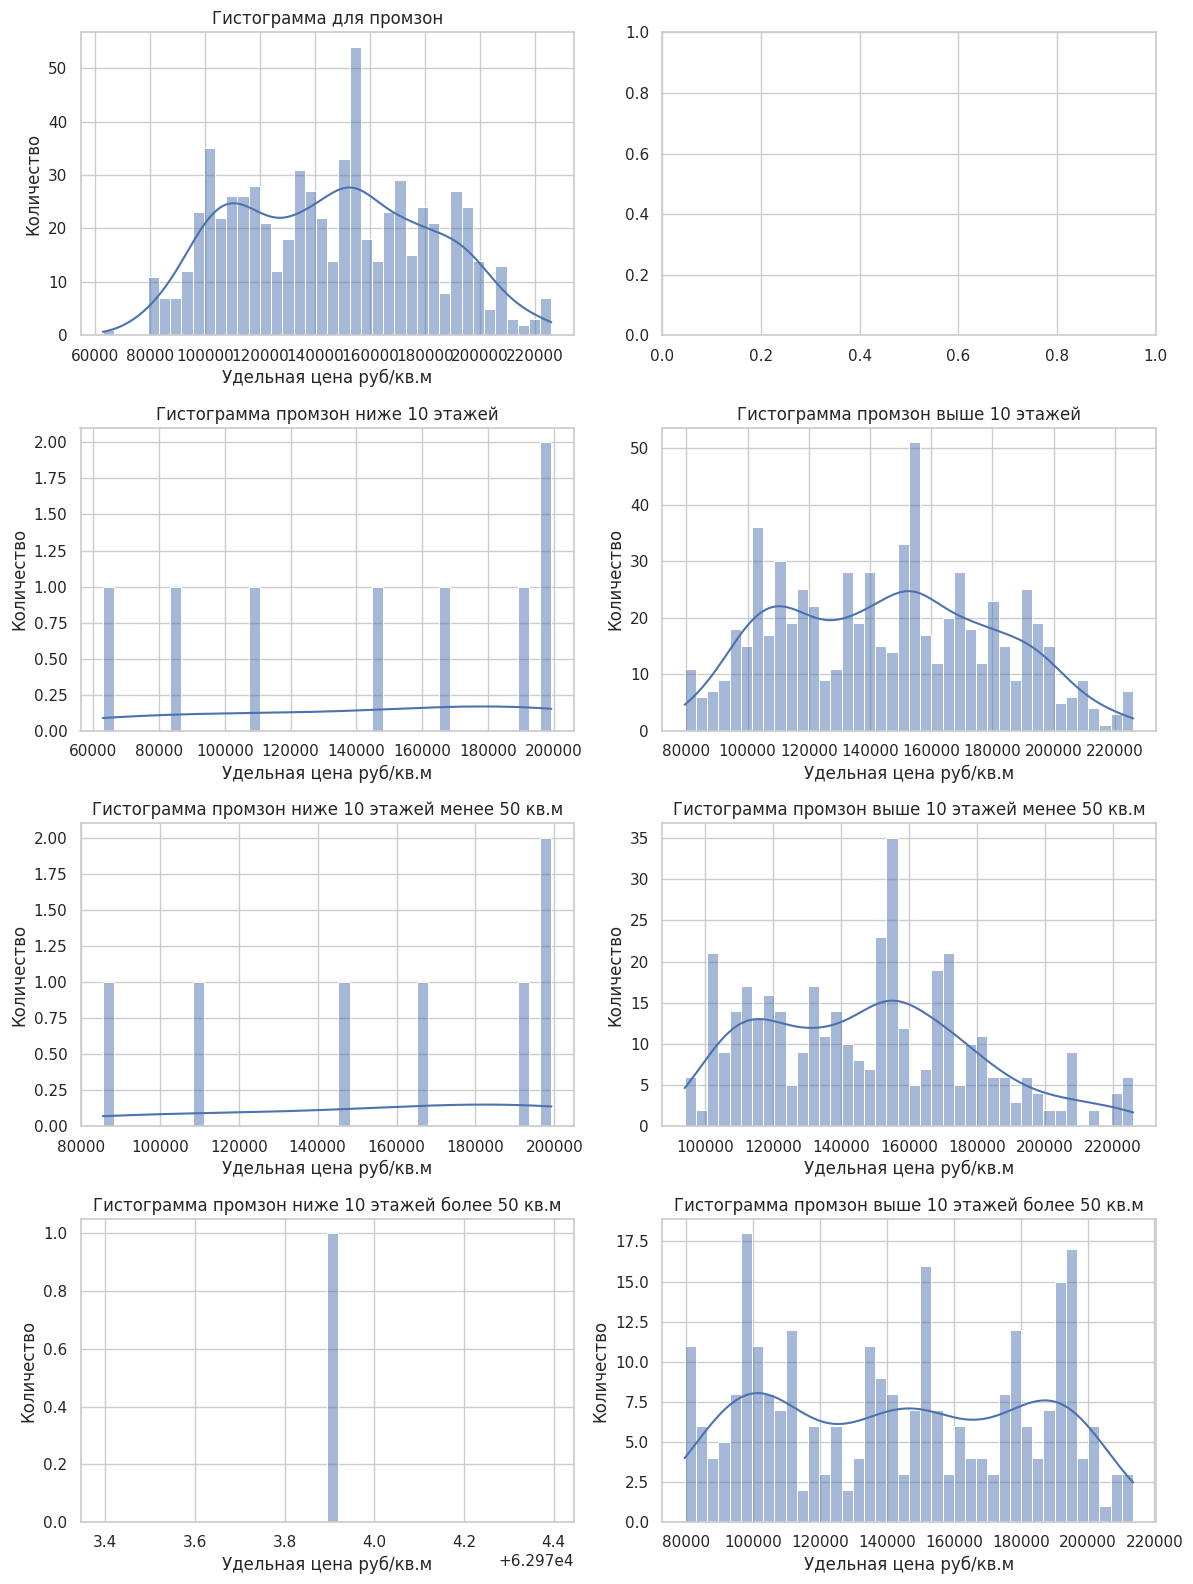

Для всей ценовой зоны: 
Среднее: 145928.178, Дисперсия: 1209722755.861
Для элементов выборки ниже 10 этажей: 
Среднее: 144864.842, Дисперсия: 2494818320.336
Для элементов выборки выше 10 этажей: 
Среднее: 145973.209, Дисперсия: 1195486172.948
Для элементов выборки ниже 10 этажей и площадью менее 50 кв.м: 
Среднее: 156563.549, Дисперсия: 1756343013.862
Для элементов выборки выше 10 этажей и площадью менее 50 кв.м: 
Среднее: 147940.854, Дисперсия: 972145894.228
Для элементов выборки ниже 10 этажей и площадью более 50 кв.м: 
Среднее: 62973.895, Дисперсия: 0.000
Для элементов выборки выше 10 этажей и площадью более 50 кв.м: 
Среднее: 143225.534, Дисперсия: 1494408751.506


In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
feat = 'Удельная цена руб/кв.м'
subdiv_stories = 10
subdiv_space = 50
i = 0
ax = axs[i // 2, i % 2]
df_MZhS = df_no_outliers[df_no_outliers['Ценовая зона'] == 'Промзоны']
sns.histplot(data = df_MZhS, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма для промзон')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 2
ax = axs[i // 2, i % 2]
df_MZhS_l10 = df_MZhS[df_MZhS['Этажей_'] < subdiv_stories]
sns.histplot(data = df_MZhS_l10, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма промзон ниже {subdiv_stories} этажей')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10 = df_MZhS[df_MZhS['Этажей_'] >= subdiv_stories]
sns.histplot(data = df_MZhS_m10, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма промзон выше {subdiv_stories} этажей')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_l10_Sl50 = df_MZhS_l10[df_MZhS_l10['Общая площадь, кв.м'] < subdiv_space]
sns.histplot(data = df_MZhS_l10_Sl50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма промзон ниже {subdiv_stories} этажей менее {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10_Sl50 = df_MZhS_m10[df_MZhS_m10['Общая площадь, кв.м'] < subdiv_space]
sns.histplot(data = df_MZhS_m10_Sl50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма промзон выше {subdiv_stories} этажей менее {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_l10_Sm50 = df_MZhS_l10[df_MZhS_l10['Общая площадь, кв.м'] >= subdiv_space]
sns.histplot(data = df_MZhS_l10_Sm50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма промзон ниже {subdiv_stories} этажей более {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10_Sm50 = df_MZhS_m10[df_MZhS_m10['Общая площадь, кв.м'] >= subdiv_space]
sns.histplot(data = df_MZhS_m10_Sm50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма промзон выше {subdiv_stories} этажей более {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
plt.tight_layout()
plt.show()
print(f'Для всей ценовой зоны: ')
print(f'Среднее: {np.mean(df_MZhS[feat]):.3f}, Дисперсия: {np.var(df_MZhS[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей: ')
print(f'Среднее: {np.mean(df_MZhS_l10[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей: ')
print(f'Среднее: {np.mean(df_MZhS_m10[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей и площадью менее {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_l10_Sl50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10_Sl50[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей и площадью менее {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_m10_Sl50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10_Sl50[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей и площадью более {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_l10_Sm50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10_Sm50[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей и площадью более {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_m10_Sm50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10_Sm50[feat]):.3f}')

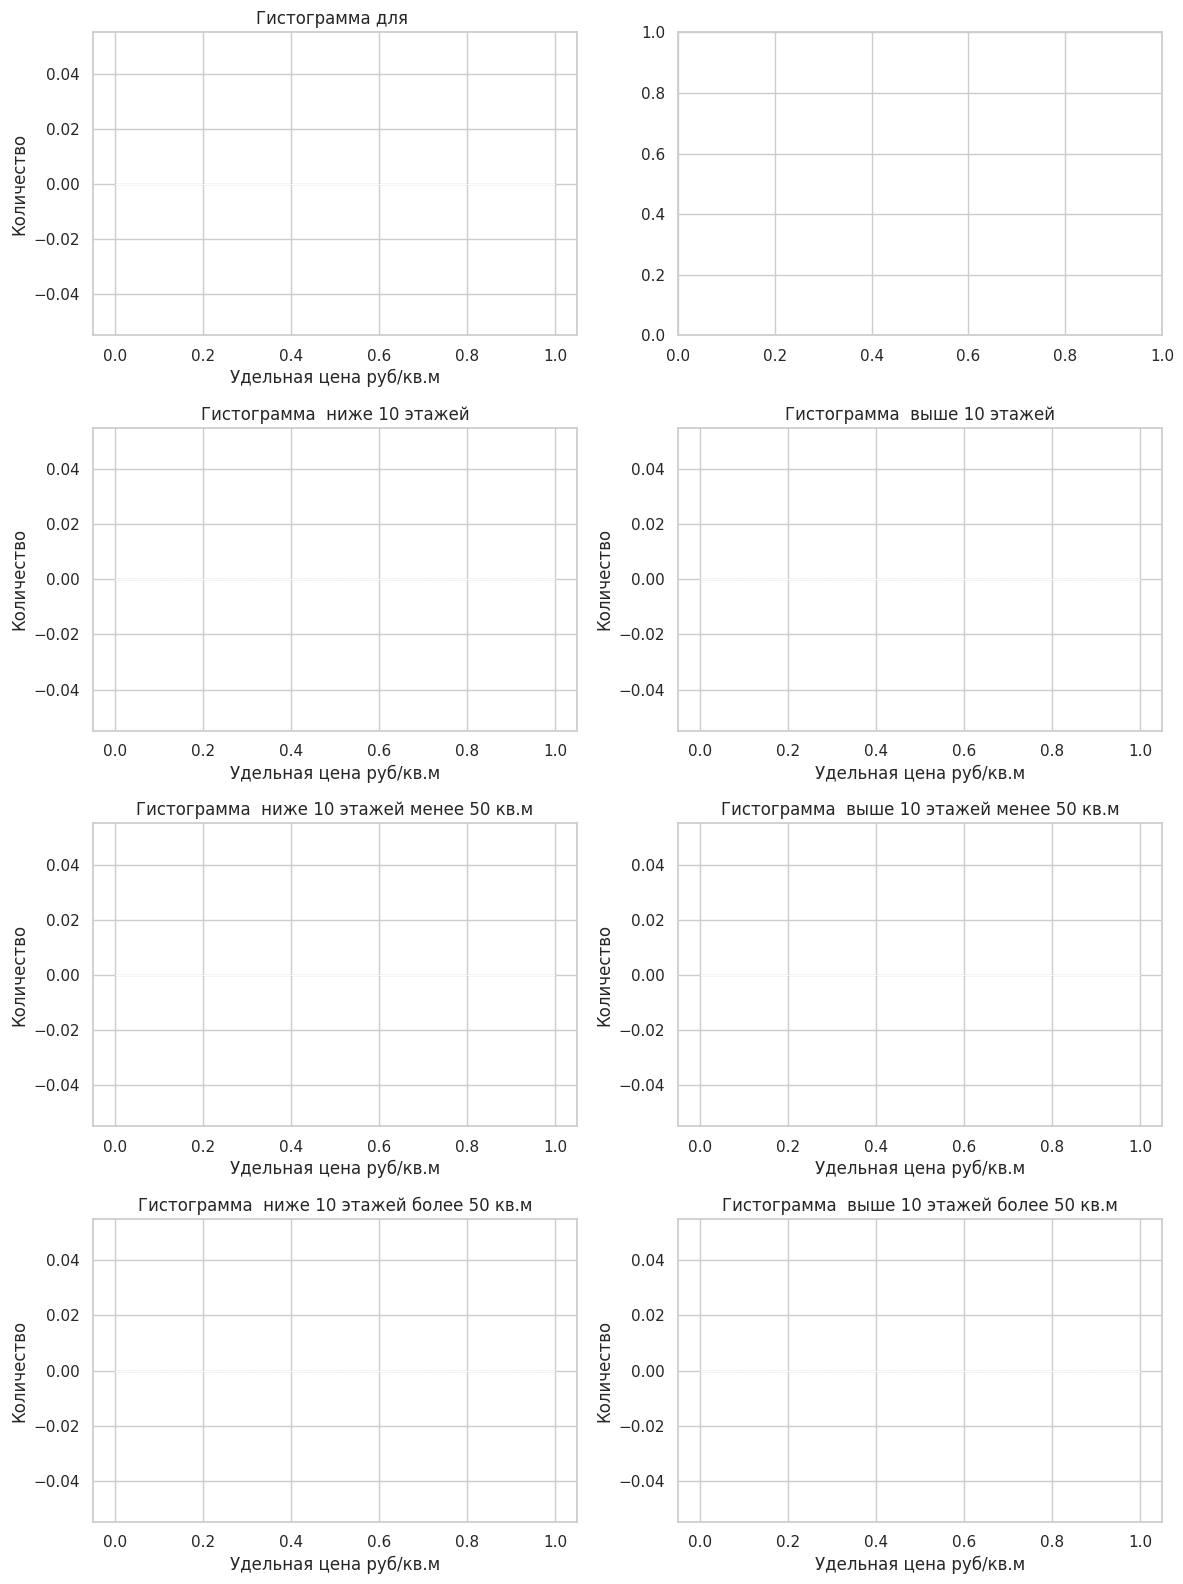

Для всей ценовой зоны: 
Среднее: nan, Дисперсия: nan
Для элементов выборки ниже 10 этажей: 
Среднее: nan, Дисперсия: nan
Для элементов выборки выше 10 этажей: 
Среднее: nan, Дисперсия: nan
Для элементов выборки ниже 10 этажей и площадью менее 50 кв.м: 
Среднее: nan, Дисперсия: nan
Для элементов выборки выше 10 этажей и площадью менее 50 кв.м: 
Среднее: nan, Дисперсия: nan
Для элементов выборки ниже 10 этажей и площадью более 50 кв.м: 
Среднее: nan, Дисперсия: nan
Для элементов выборки выше 10 этажей и площадью более 50 кв.м: 
Среднее: nan, Дисперсия: nan


In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
feat = 'Удельная цена руб/кв.м'
subdiv_stories = 10
subdiv_space = 50
i = 0
ax = axs[i // 2, i % 2]
df_MZhS = df_no_outliers[df_no_outliers['Ценовая зона'] == '']
sns.histplot(data = df_MZhS, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма для ')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 2
ax = axs[i // 2, i % 2]
df_MZhS_l10 = df_MZhS[df_MZhS['Этажей_'] < subdiv_stories]
sns.histplot(data = df_MZhS_l10, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма  ниже {subdiv_stories} этажей')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10 = df_MZhS[df_MZhS['Этажей_'] >= subdiv_stories]
sns.histplot(data = df_MZhS_m10, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма  выше {subdiv_stories} этажей')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_l10_Sl50 = df_MZhS_l10[df_MZhS_l10['Общая площадь, кв.м'] < subdiv_space]
sns.histplot(data = df_MZhS_l10_Sl50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма  ниже {subdiv_stories} этажей менее {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10_Sl50 = df_MZhS_m10[df_MZhS_m10['Общая площадь, кв.м'] < subdiv_space]
sns.histplot(data = df_MZhS_m10_Sl50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма  выше {subdiv_stories} этажей менее {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_l10_Sm50 = df_MZhS_l10[df_MZhS_l10['Общая площадь, кв.м'] >= subdiv_space]
sns.histplot(data = df_MZhS_l10_Sm50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма  ниже {subdiv_stories} этажей более {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
i += 1
ax = axs[i // 2, i % 2]
df_MZhS_m10_Sm50 = df_MZhS_m10[df_MZhS_m10['Общая площадь, кв.м'] >= subdiv_space]
sns.histplot(data = df_MZhS_m10_Sm50, x = feat, bins = 40, kde = True, ax = ax)
ax.set_title(f'Гистограмма  выше {subdiv_stories} этажей более {subdiv_space} кв.м')
ax.set_xlabel(feat)
ax.set_ylabel('Количество')
plt.tight_layout()
plt.show()
print(f'Для всей ценовой зоны: ')
print(f'Среднее: {np.mean(df_MZhS[feat]):.3f}, Дисперсия: {np.var(df_MZhS[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей: ')
print(f'Среднее: {np.mean(df_MZhS_l10[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей: ')
print(f'Среднее: {np.mean(df_MZhS_m10[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей и площадью менее {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_l10_Sl50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10_Sl50[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей и площадью менее {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_m10_Sl50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10_Sl50[feat]):.3f}')
print(f'Для элементов выборки ниже {subdiv_stories} этажей и площадью более {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_l10_Sm50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_l10_Sm50[feat]):.3f}')
print(f'Для элементов выборки выше {subdiv_stories} этажей и площадью более {subdiv_space} кв.м: ')
print(f'Среднее: {np.mean(df_MZhS_m10_Sm50[feat]):.3f}, Дисперсия: {np.var(df_MZhS_m10_Sm50[feat]):.3f}')